# Resumen

De momento lo que he hecho es:
* L2 y L3 fueron mis primeras tablas, solo saqué división en el gasto por cliente, 2 clusters, algo muy básico. Vi que todos los clientes son igual de frecuentes.
* A L4 y L5 les añadí top región, categoría y producto por cliente. La categoría no cambia y saqué 2 clusters con el mismo número de clientes que en el anterior, solo que ahora también sabía la región y producto top de los clusters.
* L6 está agrupada por cliente y producto, y tiene estadísticas interesantes. Al principio hice un pivoteo de la tabla que me acabó separando los clientes por región, 16 clusters. No me pareció buena clusterización.
    
    Lo siguiente que hice fue, en vez de pivotear, codificar las categóricas y aplicar clusterización. Acabé obteniendo 10 clusters con datos interesantes de cada uno, inlcuso uniendo la información de la tabla l7 que es de coocurrencias de productos por cliente. Pero como L6 está agrupado por cliente y producto, habían clientes que pertenecían a varios clusters a la vez, por lo que no lo vi adecuado.

    Por último, he agrupado toda la información de l6 a nivel de cliente, con los que he conseguido finalmente 4 clusters con bastante información de cada uno. Tras combinar la información con la tabla de coocurrencias l7, se puede ver cuáles son los pares de productos preferidos de cada cluster, entre otro tipo de información

# L2 y L3

### Cargamos los datos de Snowflake

In [116]:
from sqlalchemy import create_engine
import pandas as pd

user = 'PERKYGENIUS27'
password = 'Sopomanitanio27'
account = 'bdfuagx-fv18223'
database = 'practicas_nubita'
schema = 'LND'
warehouse = 'COMPUTE_WH'

engine = create_engine(
    f'snowflake://{user}:{password}@{account}/{database}/{schema}?warehouse={warehouse}'
)

query = "SELECT * FROM LND.ods_cli_l3_v_beverage_sales_data_categorizados"

df = pd.read_sql(query, engine)


In [117]:
df

customer_id  num_orders  customer_value  avg_units_per_order  \
0        CUS9770         315        51137.34            24.704762   
1        CUS2207         319       218546.16           136.003135   
2        CUS1537         312       256263.03           150.932692   
3        CUS1172         324       226005.79           156.753086   
4        CUS4901         303       266058.29           151.838284   
...          ...         ...             ...                  ...   
9995     CUS7047         285        39567.04            24.259649   
9996     CUS7278         331       294470.44           150.625378   
9997      CUS508         292        42535.59            24.397260   
9998     CUS5648         303        50899.02            24.511551   
9999     CUS9075         302       269328.57           150.500000   

      avg_spent_per_order  avg_days_between_orders  
0              162.340762                 3.455414  
1              685.097680                 3.433962  
2              821.355865                 3.466238  
3              697.548735                 3.377709  
4              878.080165                 3.596026  
...                   ...                      ...  
9995           138.831719                 3.834507  
9996           889.638792                 3.293939  
9997           145.669829                 3.718213  
9998           167.983564                 3.602649  
9999           891.816457                 3.624585  

[10000 rows x 6 columns]

### Exploramos

In [41]:
df.describe()

num_orders  customer_value  avg_units_per_order  avg_spent_per_order  \
count  10000.000000    10000.000000         10000.000000         10000.000000   
mean     300.000000   117668.116335            69.417279           392.283891   
std       17.253057   102371.154813            61.114773           340.149904   
min      242.000000    25127.180000            21.270548            94.125292   
25%      288.000000    41144.927500            23.767659           137.997352   
50%      300.000000    46563.775000            24.609836           153.818059   
75%      311.000000   237141.907500           148.894148           796.138087   
max      359.000000   367741.610000           170.421725          1167.433683   

       avg_days_between_orders  
count             10000.000000  
mean                  3.646559  
std                   0.210923  
min                   3.039106  
25%                   3.500000  
50%                   3.636667  
75%                   3.782007  
max                   4.518672

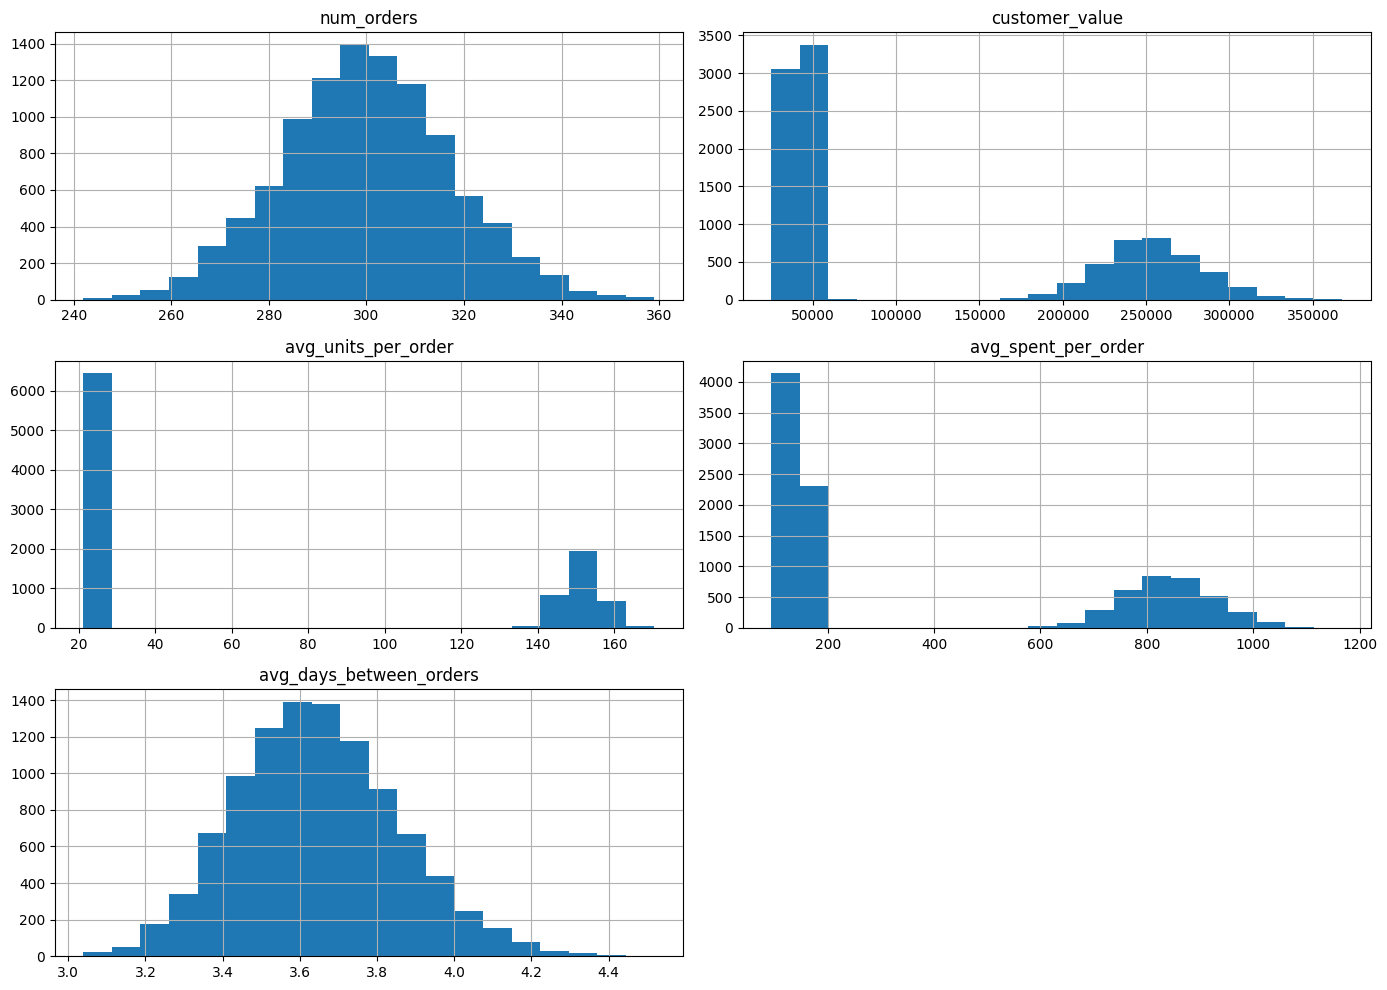

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['num_orders', 'customer_value', 'avg_units_per_order', 'avg_spent_per_order', 'avg_days_between_orders']
df[features].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

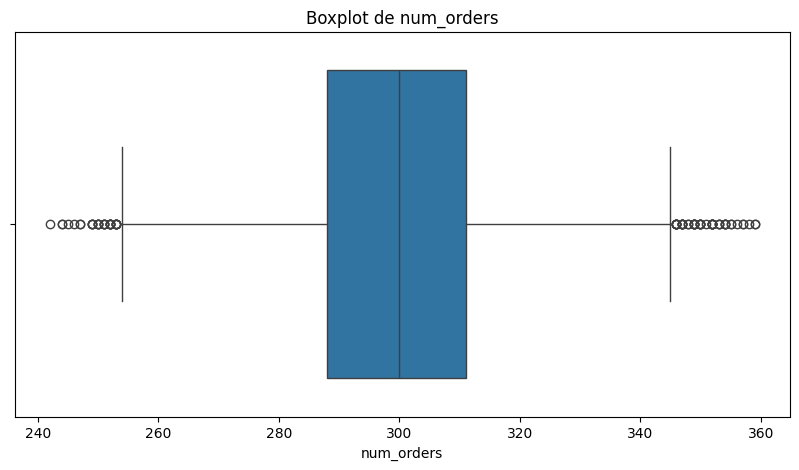

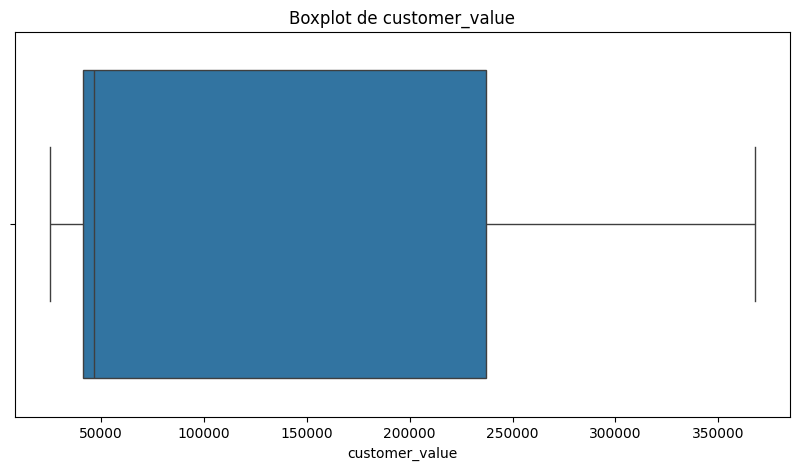

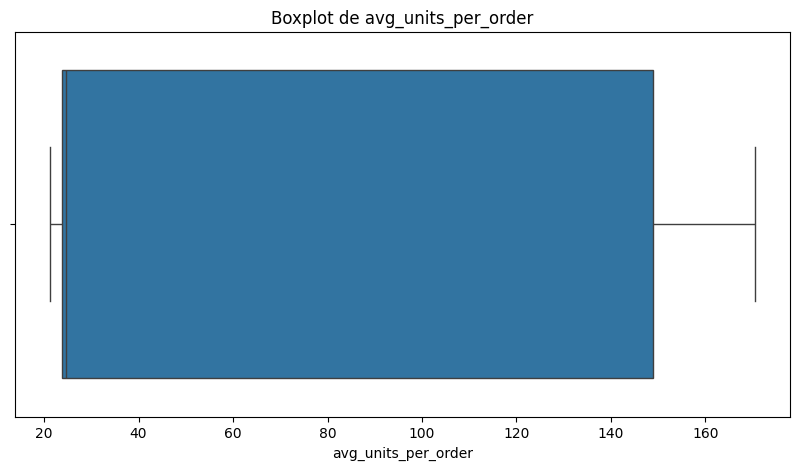

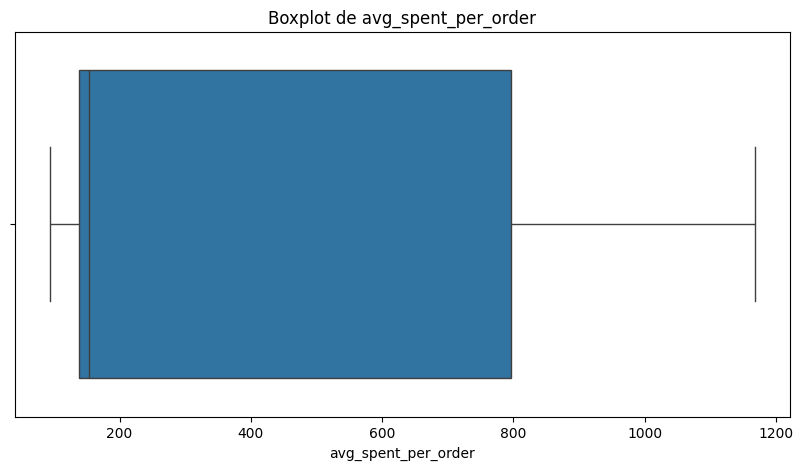

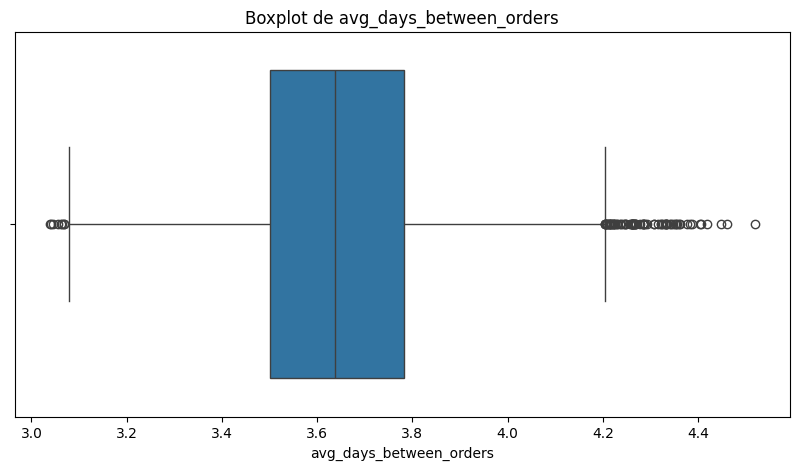

In [43]:
# Crear un boxplot para cada variable numérica
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot de {feature}')
    plt.show()


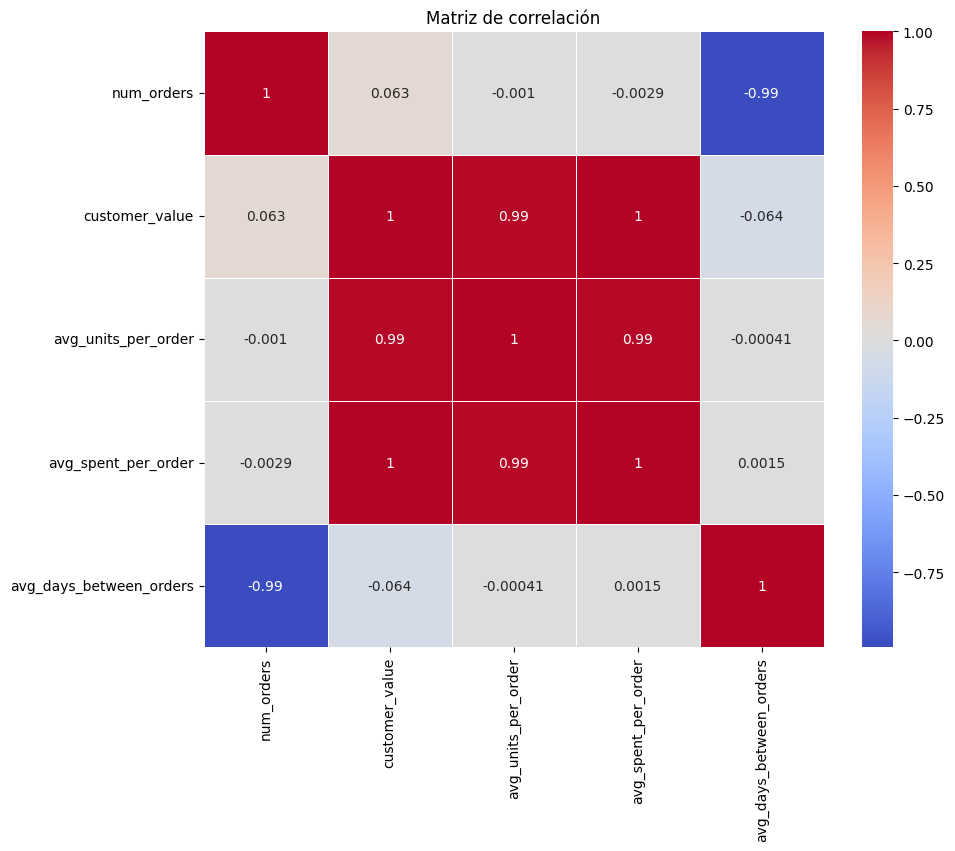

In [44]:
# Calculamos la correlación
correlation_matrix = df[features].corr()

# Mostrar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


In [45]:
df.duplicated().sum()

np.int64(0)

In [118]:
features = ['avg_spent_per_order', 'avg_days_between_orders']

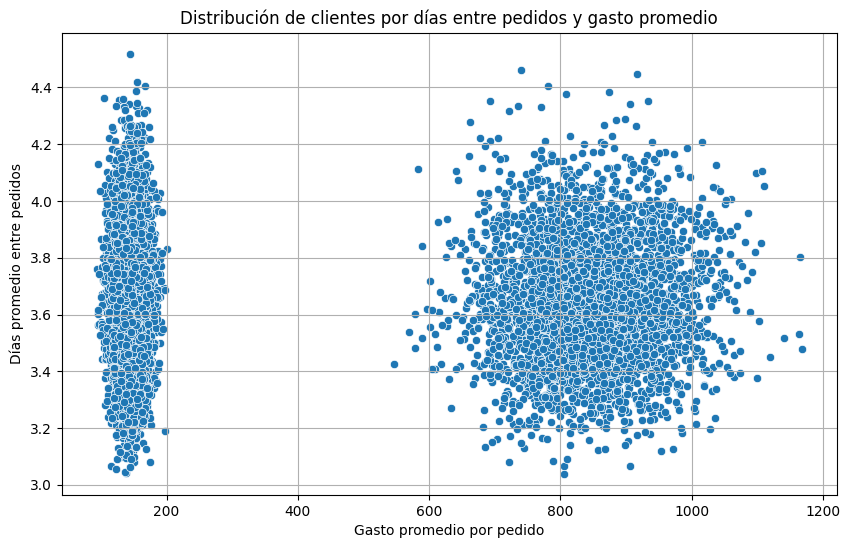

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

x = df['avg_spent_per_order']
y = df['avg_days_between_orders']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y)
plt.title('Distribución de clientes por días entre pedidos y gasto promedio')
plt.xlabel('Gasto promedio por pedido')
plt.ylabel('Días promedio entre pedidos')
plt.grid(True)
plt.show()


### Clusterización

In [120]:
from sklearn.preprocessing import StandardScaler

# Selecciona las columnas relevantes
X = df[features]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


/var/folders/6b/53qw7dps3pvfkphrkbx_yn940000gn/T/ipykernel_41114/3887687567.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


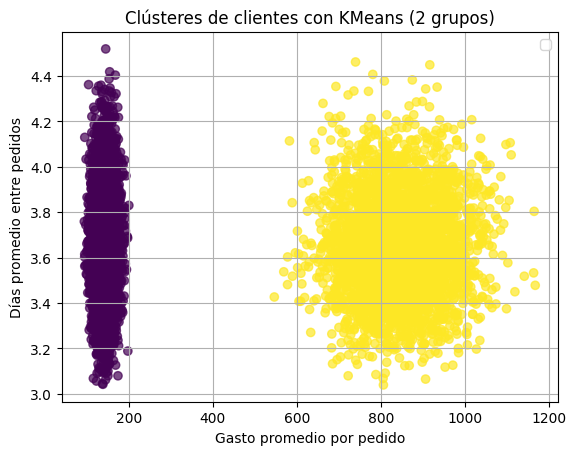

In [121]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters
plt.scatter(x = df['avg_spent_per_order'], y = df['avg_days_between_orders'],
            c=clusters, cmap='viridis', alpha=0.7)

plt.xlabel('Gasto promedio por pedido')
plt.ylabel('Días promedio entre pedidos')
plt.title('Clústeres de clientes con KMeans (2 grupos)')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(X_scaled, clusters)
print("Silhouette score para 2 clusters:", silhouette)

Silhouette score para 2 clusters: 0.5359519420324675


In [51]:
df

customer_id  num_orders  customer_value  avg_units_per_order  \
0        CUS9770         315        51137.34            24.704762   
1        CUS2207         319       218546.16           136.003135   
2        CUS1537         312       256263.03           150.932692   
3        CUS4901         303       266058.29           151.838284   
4        CUS4230         297        37433.49            23.296296   
...          ...         ...             ...                  ...   
9995     CUS7047         285        39567.04            24.259649   
9996     CUS7278         331       294470.44           150.625378   
9997      CUS508         292        42535.59            24.397260   
9998     CUS5648         303        50899.02            24.511551   
9999     CUS9075         302       269328.57           150.500000   

      avg_spent_per_order  avg_days_between_orders  cluster  
0              162.340762                 3.455414        0  
1              685.097680                 3.433962        1  
2              821.355865                 3.466238        1  
3              878.080165                 3.596026        1  
4              126.038687                 3.675676        0  
...                   ...                      ...      ...  
9995           138.831719                 3.834507        0  
9996           889.638792                 3.293939        1  
9997           145.669829                 3.718213        0  
9998           167.983564                 3.602649        0  
9999           891.816457                 3.624585        1  

[10000 rows x 7 columns]

In [52]:
df_cluster = df.groupby('cluster')[features].mean()
df_cluster

avg_spent_per_order  avg_days_between_orders
cluster                                              
0                 142.423026                 3.646596
1                 843.688434                 3.646491

La variable avg_days_between_orders no está aportando separación.

In [123]:
df.groupby('cluster').count()

customer_id  num_orders  customer_value  avg_units_per_order  \
cluster                                                                 
0               6437        6437            6437                 6437   
1               3563        3563            3563                 3563   

         avg_spent_per_order  avg_days_between_orders  
cluster                                                
0                       6437                     6437  
1                       3563                     3563

# L4 y L5

In [70]:
from sqlalchemy import create_engine
import pandas as pd

user = 'PERKYGENIUS27'
password = 'Sopomanitanio27'
account = 'bdfuagx-fv18223'
database = 'practicas_nubita'
schema = 'LND'
warehouse = 'COMPUTE_WH'

engine = create_engine(
    f'snowflake://{user}:{password}@{account}/{database}/{schema}?warehouse={warehouse}'
)

query = "SELECT * FROM LND.ods_cli_l5_v_beverage_sales_data_categorizados"

df = pd.read_sql(query, engine)


In [71]:
df

customer_id  avg_spent_per_order  avg_products_per_order  \
0        CUS7894           150.360975                3.133574   
1        CUS5205           158.681263                3.063158   
2        CUS3280           138.595492                2.969492   
3        CUS6472           149.459877                2.907407   
4        CUS4733           719.354559                3.024316   
...          ...                  ...                     ...   
9995     CUS7019           161.635430                3.102649   
9996     CUS6662           164.957962                2.955414   
9997     CUS5135           137.056860                2.941980   
9998     CUS6842           136.876711                3.161184   
9999     CUS5703           144.920234                2.986622   

      avg_days_between_orders           top_region         top_category  \
0                    3.884058      Rheinland-Pfalz  Alcoholic Beverages   
1                    3.827465              Sachsen  Alcoholic Beverages   
2                    3.704082  Nordrhein-Westfalen  Alcoholic Beverages   
3                    3.374613               Berlin  Alcoholic Beverages   
4                    3.329268   Schleswig-Holstein  Alcoholic Beverages   
...                       ...                  ...                  ...   
9995                 3.607973               Bayern  Alcoholic Beverages   
9996                 3.479233       Sachsen-Anhalt  Alcoholic Beverages   
9997                 3.736301              Hamburg  Alcoholic Beverages   
9998                 3.580858               Bremen  Alcoholic Beverages   
9999                 3.661074   Schleswig-Holstein  Alcoholic Beverages   

          top_product dominant_customer_type  
0         Apollinaris                    B2c  
1         Apollinaris                    B2c  
2               Evian                    B2c  
3         Apollinaris                    B2c  
4         Apollinaris                    B2b  
...               ...                    ...  
9995     Gerolsteiner                    B2c  
9996      Apollinaris                    B2c  
9997  Cranberry Juice                    B2c  
9998           Beck's                    B2c  
9999    Granini Apple                    B2c  

[10000 rows x 8 columns]

### Exploramos

In [72]:
df.describe()

avg_spent_per_order  avg_products_per_order  avg_days_between_orders
count         10000.000000            10000.000000             10000.000000
mean            392.283891                2.999949                 3.646559
std             340.149904                0.081301                 0.210923
min              94.125292                2.681319                 3.039106
25%             137.997352                2.945205                 3.500000
50%             153.818059                3.000000                 3.636667
75%             796.138087                3.054222                 3.782007
max            1167.433683                3.300000                 4.518672

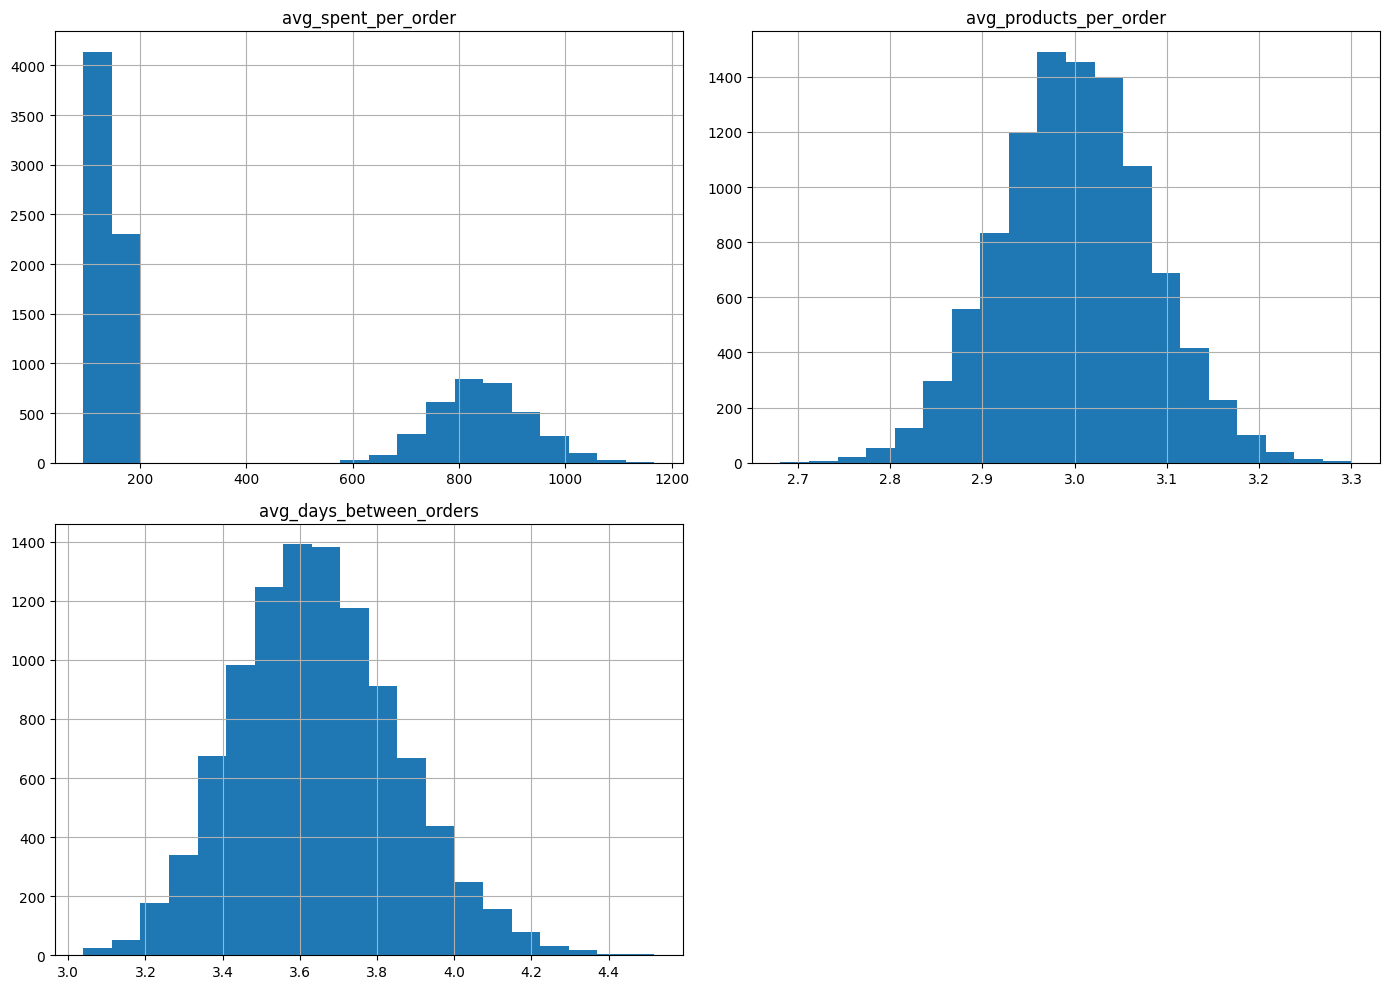

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['avg_spent_per_order', 'avg_products_per_order', 'avg_days_between_orders']
df[num_cols].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

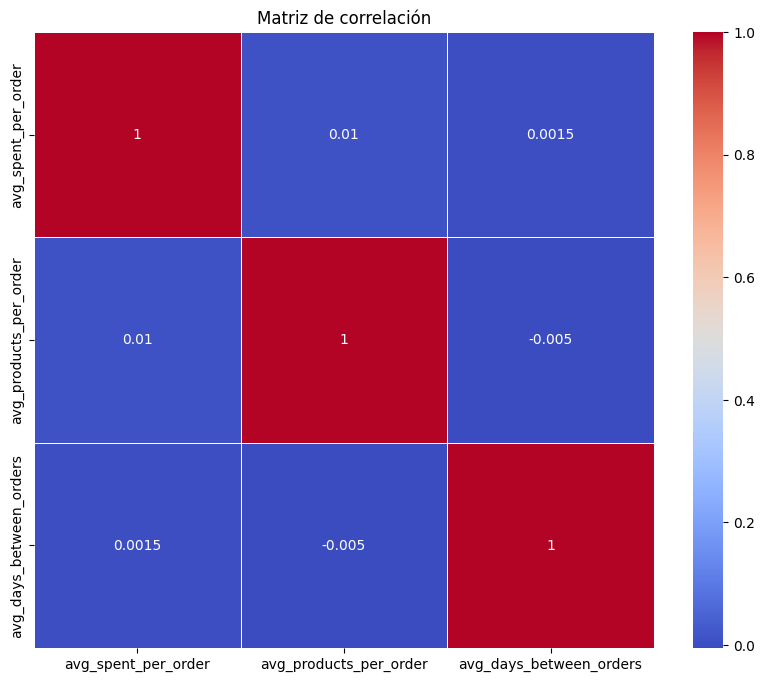

In [74]:
# Calculamos la correlación
correlation_matrix = df[num_cols].corr()

# Mostrar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


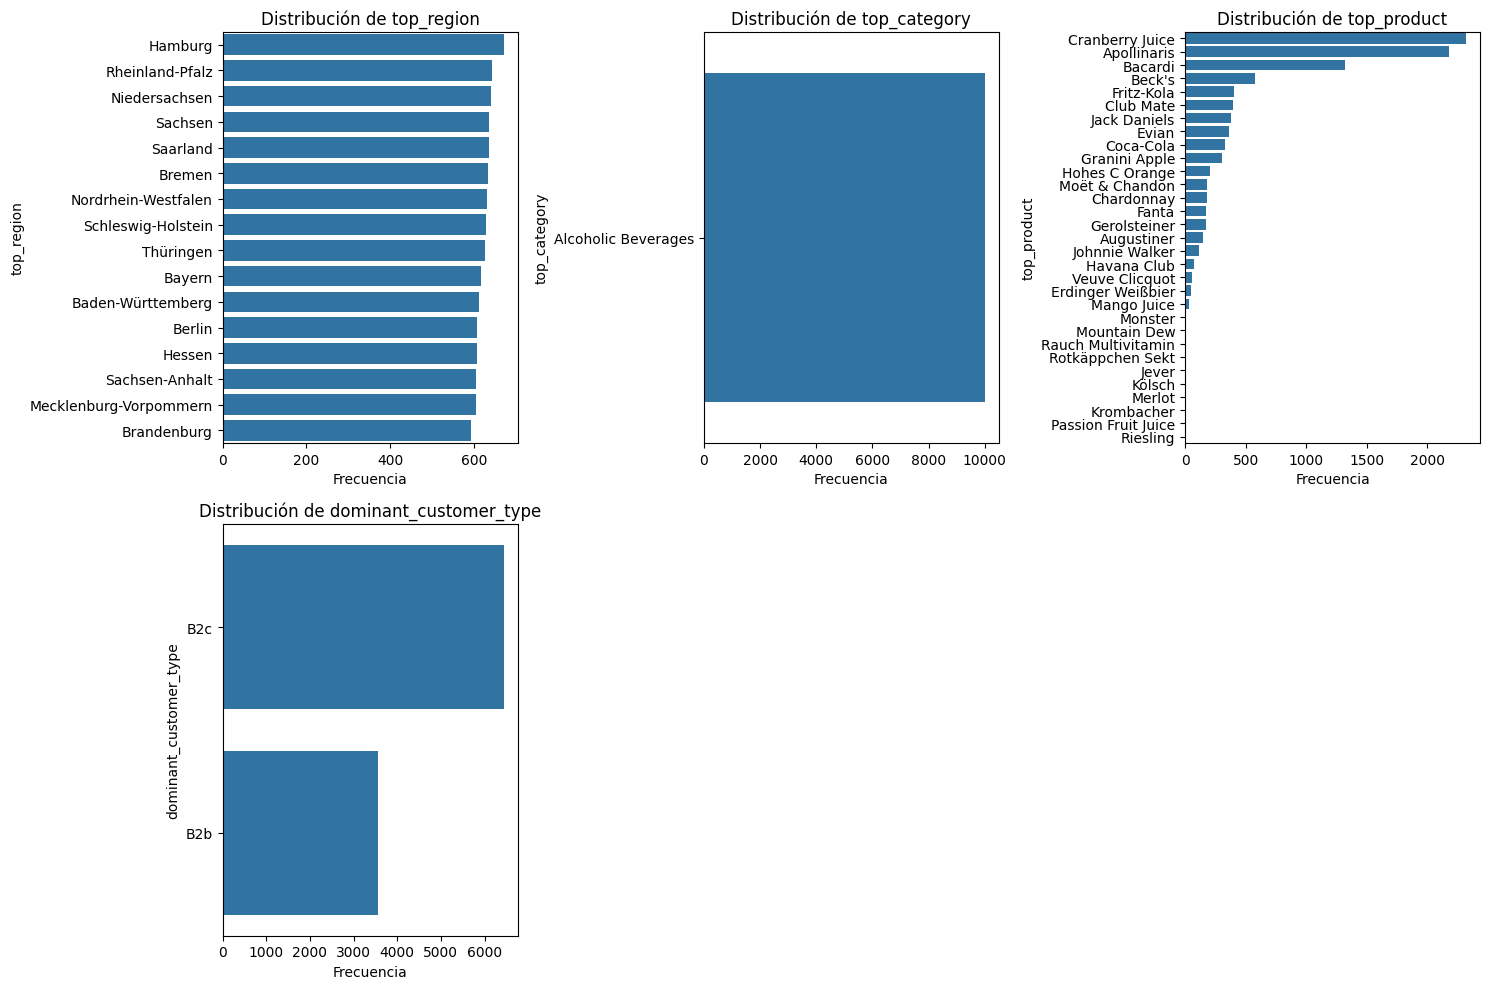

In [75]:
cat_cols = ['top_region', 'top_category', 'top_product', 'dominant_customer_type']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, y=feature, order=df[feature].value_counts().index)
    plt.title(f'Distribución de {feature}')
    plt.xlabel('Frecuencia')
    plt.tight_layout()

plt.show()

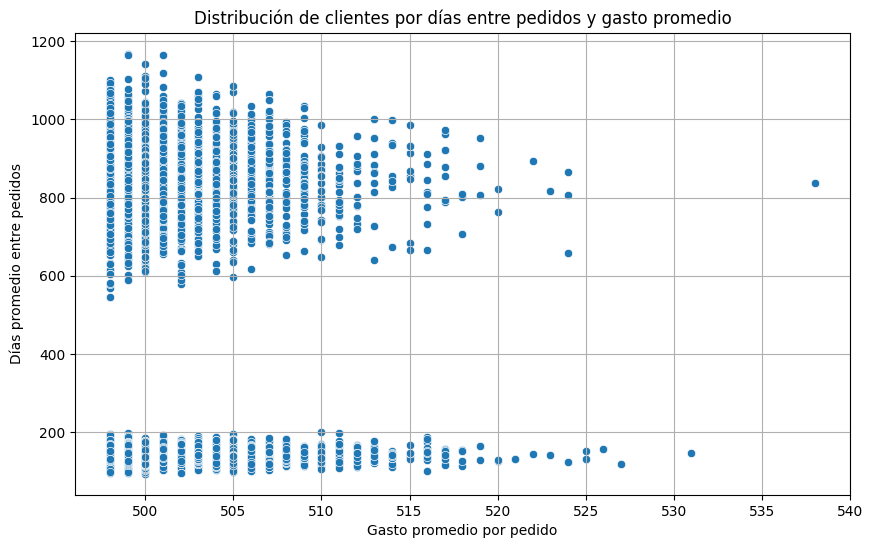

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

x = df['promedio_por_pedido']
y = df['dias_desde_ultima_compra']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=x)
plt.title('Distribución de clientes por días entre pedidos y gasto promedio')
plt.xlabel('Gasto promedio por pedido')
plt.ylabel('Días promedio entre pedidos')
plt.grid(True)
plt.show()


### Clusterización

In [ ]:
!pip install kmodes
!pip install keras



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [109]:
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])
df_scaled = df.drop(columns=['customer_id'])


# Convertir a matriz (KPrototypes requiere numpy)
X = df_scaled[['avg_spent_per_order', 'top_product', 'top_region', 'dominant_customer_type']].to_numpy()

# Ejecutar el modelo
kproto = KPrototypes(n_clusters=2, init='Huang', random_state=42)
clusters = kproto.fit_predict(X, categorical=[1,2,3])

In [110]:
df['cluster'] = clusters

In [111]:
# Resumen estadístico de los clusters
cluster_summary = df.groupby('cluster').count()
print(cluster_summary)


         customer_id  avg_spent_per_order  avg_products_per_order  \
cluster                                                             
0               3563                 3563                    3563   
1               6437                 6437                    6437   

         avg_days_between_orders  top_region  top_category  top_product  \
cluster                                                                   
0                           3563        3563          3563         3563   
1                           6437        6437          6437         6437   

         dominant_customer_type  
cluster                          
0                          3563  
1                          6437  


In [112]:
df.groupby('cluster').agg({
    'avg_spent_per_order': ['mean', 'std'],
    'top_region': pd.Series.mode,
    'top_product': pd.Series.mode,
    'dominant_customer_type': pd.Series.mode
})


avg_spent_per_order                top_region      top_product  \
                       mean        std           mode             mode   
cluster                                                                  
0                843.688434  87.896519        Hamburg          Bacardi   
1                142.423026  15.272940  Niedersachsen  Cranberry Juice   

        dominant_customer_type  
                          mode  
cluster                         
0                          B2b  
1                          B2c

# Notas

Todos los clientes son frecuentes y no les afectan los descuentos

Luego de añadir las categorías top, nos sigue dando la misma clusterización que al principio.

Cada cliente compra en un único sitio

# L6 y L7

In [124]:
from sqlalchemy import create_engine
import pandas as pd

user = 'PERKYGENIUS27'
password = 'Sopomanitanio27'
account = 'bdfuagx-fv18223'
database = 'practicas_nubita'
schema = 'LND'
warehouse = 'COMPUTE_WH'

engine = create_engine(
    f'snowflake://{user}:{password}@{account}/{database}/{schema}?warehouse={warehouse}'
)

query = "SELECT * FROM LND.ods_cli_l6_v_beverage_sales_data_categorizados"

df = pd.read_sql(query, engine)


In [125]:
df

customer_id              product             category  \
0          CUS3177          Mango Juice               Juices   
1          CUS7564             Riesling  Alcoholic Beverages   
2          CUS1617  Passion Fruit Juice               Juices   
3          CUS4577       Johnnie Walker  Alcoholic Beverages   
4          CUS5994              Selters                Water   
...            ...                  ...                  ...   
469995     CUS7095             Riesling  Alcoholic Beverages   
469996     CUS5098         Jack Daniels  Alcoholic Beverages   
469997     CUS7723           Warsteiner  Alcoholic Beverages   
469998     CUS9207              Bacardi  Alcoholic Beverages   
469999     CUS3826                Jever  Alcoholic Beverages   

                     region  num_orders  total_quantity  total_spent  \
0               Brandenburg          37             271       874.60   
1           Rheinland-Pfalz          24             143       612.03   
2         Baden-Württemberg          31            1195      3324.69   
3                    Bayern           9              67      2443.51   
4                    Bayern          29            1431      1159.85   
...                     ...         ...             ...          ...   
469995               Bremen           3              95       755.62   
469996  Nordrhein-Westfalen           3              20       975.80   
469997          Brandenburg           4              25        25.83   
469998      Rheinland-Pfalz           2              15       201.60   
469999       Sachsen-Anhalt           2              28        53.42   

        avg_unit_price  avg_discount first_order_date last_order_date  \
0             3.233784      0.000000       2021-01-09      2023-12-25   
1             4.260417      0.000000       2021-01-10      2023-12-03   
2             2.870968      0.069355       2021-01-18      2023-12-27   
3            36.600000      0.000000       2021-01-21      2023-09-15   
4             0.836552      0.087931       2021-01-29      2023-12-07   
...                ...           ...              ...             ...   
469995        8.006667      0.083333       2022-07-05      2022-10-17   
469996       48.790000      0.000000       2021-03-19      2021-12-23   
469997        1.042500      0.000000       2021-02-25      2023-03-26   
469998       13.440000      0.000000       2021-03-24      2021-12-16   
469999        1.910000      0.000000       2021-12-06      2022-12-15   

        num_lines  
0              37  
1              24  
2              31  
3               9  
4              29  
...           ...  
469995          3  
469996          3  
469997          4  
469998          2  
469999          2  

[470000 rows x 12 columns]

In [167]:
print('categorias: ', len(df['category'].unique()))
print('productos: ', len(df['product'].unique()))
print('regiones', len(df['region'].unique()))


categorias:  4
productos:  47
regiones 16


In [160]:
"CUS05" in df["customer_id"].values


False

## Me quedan 16 clusters

### kmeans

In [175]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df_pivot = df.pivot_table(
    index='customer_id',
    columns=['region', 'category', 'product'],
    values='num_orders',
    aggfunc='sum',
    fill_value=0
)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)

# Clusterización (puedes probar con más valores de k)
kmeans_2 = KMeans(n_clusters=2, random_state=42)
clusters_2 = kmeans_2.fit_predict(X_scaled)

kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(X_scaled)

kmeans_4 = KMeans(n_clusters=4, random_state=42)
clusters_4 = kmeans_4.fit_predict(X_scaled)

# Añadir cluster a la tabla
df_pivot['cluster'] = clusters_2

df_pivot


region        Baden-Württemberg                                              \
category    Alcoholic Beverages                                               
product              Augustiner Bacardi Beck's Chardonnay Erdinger Weißbier   
customer_id                                                                   
CUS1                          0       0      0          0                 0   
CUS10                         0       0      0          0                 0   
CUS100                        0       0      0          0                 0   
CUS1000                       0       0      0          0                 0   
CUS10000                      0       0      0          0                 0   
...                         ...     ...    ...        ...               ...   
CUS9995                       0       0      0          0                 0   
CUS9996                       0       0      0          0                 0   
CUS9997                       0       0      0          0                 0   
CUS9998                       0       0      0          0                 0   
CUS9999                       0       0      0          0                 0   

region                                                                ...  \
category                                                              ...   
product     Havana Club Jack Daniels Jever Johnnie Walker Krombacher  ...   
customer_id                                                           ...   
CUS1                  0            0     0              0          0  ...   
CUS10                 0            0     0              0          0  ...   
CUS100                0            0     0              0          0  ...   
CUS1000               0            0     0              0          0  ...   
CUS10000              0            0     0              0          0  ...   
...                 ...          ...   ...            ...        ...  ...   
CUS9995               0            0     0              0          0  ...   
CUS9996               0            0     0              0          0  ...   
CUS9997               0            0     0              0          0  ...   
CUS9998               0            0     0              0          0  ...   
CUS9999               0            0     0              0          0  ...   

region        Thüringen                                                       \
category          Water                                                        
product     Apollinaris Evian Gerolsteiner San Pellegrino Selters Vio Wasser   
customer_id                                                                    
CUS1                  0     0            0              0       0          0   
CUS10                 0     0            0              0       0          0   
CUS100                0     0            0              0       0          0   
CUS1000              18    24           24             30      29         14   
CUS10000              0     0            0              0       0          0   
...                 ...   ...          ...            ...     ...        ...   
CUS9995               0     0            0              0       0          0   
CUS9996               0     0            0              0       0          0   
CUS9997               0     0            0              0       0          0   
CUS9998               0     0            0              0       0          0   
CUS9999               0     0            0              0       0          0   

region                                 cluster  
category                                        
product     Vittel Volvic Volvic Touch          
customer_id                                     
CUS1             0      0            0       0  
CUS10            0      0            0       0  
CUS100           0      0            0       0  
CUS1000         29     19           23       0  
CUS10000         0      0            0       0  
...            .

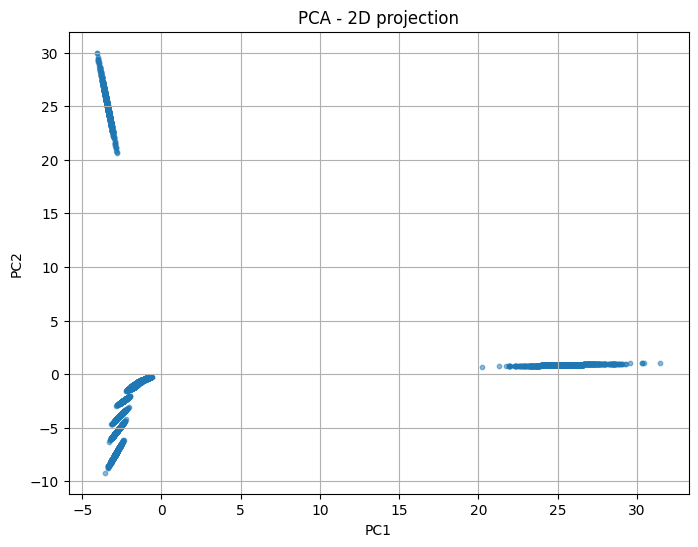

In [168]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.5, s=10)
plt.title("PCA - 2D projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [176]:
from sklearn.metrics import silhouette_score

#calculamos los coeficientes de Silhouette para 2, 3 y 5 clusters
silhouette_2 = silhouette_score(X_scaled, clusters_2)
silhouette_3 = silhouette_score(X_scaled, clusters_3)
silhouette_4 = silhouette_score(X_scaled, clusters_4)

print("Silhouette score para 2 clusters:", silhouette_2)
print("Silhouette score para 3 clusters:", silhouette_3)
print("Silhouette score para 4 clusters:", silhouette_4)

#se ha usado gemini como ayuda para escribir automáticamente esto

Silhouette score para 2 clusters: 0.10022346041589042
Silhouette score para 3 clusters: 0.13993251956041844
Silhouette score para 4 clusters: 0.18716532520211482


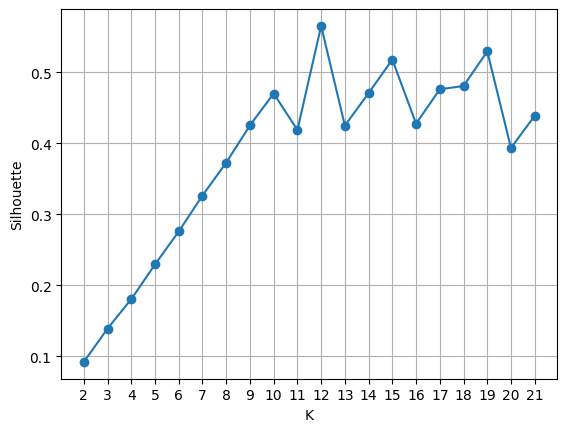

In [178]:
#vamos a usar el método del codo para ver el número óptimo de clusters
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 22):
    km = KMeans(i, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=42)
    clustering = km.fit_predict(X_scaled)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(X_scaled, clustering))

#visualizamos
plt.plot(range(2,22), silhouettes , marker='o')
plt.xticks(range(2, 22))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

In [ ]:
!pip install plotly
!pip install --upgrade nbformat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 6.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [174]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Convertir a DataFrame para graficar con Plotly
df_pca_3d = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
df_pca_3d["customer_id"] = df_pivot.index

fig = px.scatter_3d(df_pca_3d, x="PC1", y="PC2", z="PC3", hover_name="customer_id", opacity=0.6)
fig.update_layout(title="PCA - 3D projection", margin=dict(l=0, r=0, b=0, t=30))
fig.write_html("pca_3d_plot.html")


Se ven varias agrupaciones en 3d, utilizamos DBSCAN.

Primero probamos los 12 clusters a ver si se ve bien

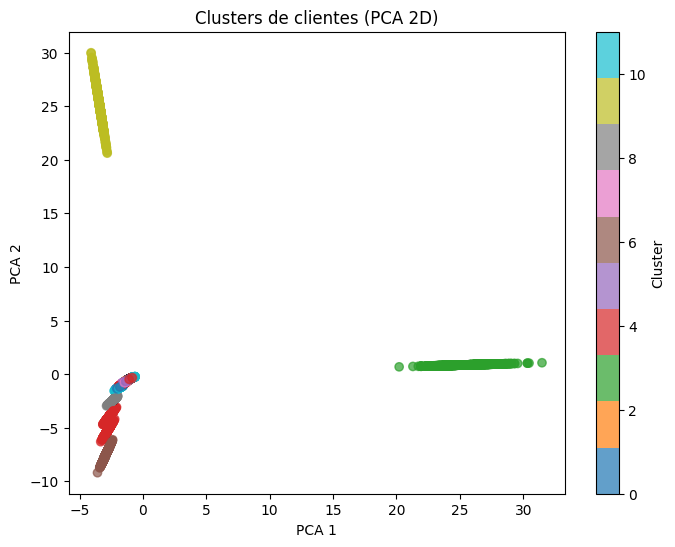

In [181]:
kmeans_12 = KMeans(n_clusters=12, random_state=42)
clusters_12 = kmeans_12.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_12, cmap='tab10', alpha=0.7)
plt.title("Clusters de clientes (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.show()

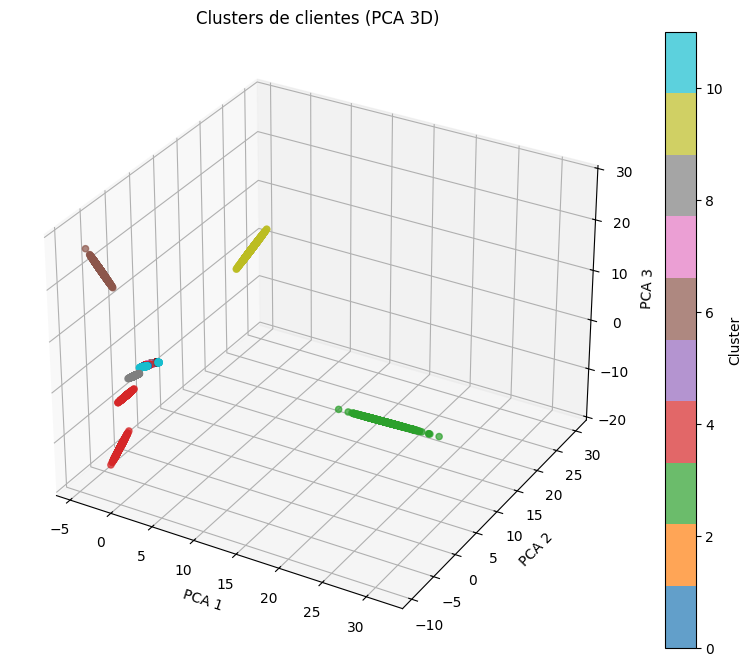

In [182]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Realizar KMeans
kmeans_12 = KMeans(n_clusters=12, random_state=42)
clusters_12 = kmeans_12.fit_predict(X_scaled)

# Crear la visualización 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos de los clusters
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_2d[:, 1], X_pca_3d[:, 2], c=clusters_12, cmap='tab10', alpha=0.7)

# Añadir etiquetas
ax.set_title("Clusters de clientes (PCA 3D)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

# Añadir barra de colores
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()


In [205]:
df_pivot.groupby('cluster').count()

region     Baden-Württemberg                                              \
category Alcoholic Beverages                                               
product           Augustiner Bacardi Beck's Chardonnay Erdinger Weißbier   
cluster                                                                    
0                       9392    9392   9392       9392              9392   
1                        608     608    608        608               608   

region                                                             ...  \
category                                                           ...   
product  Havana Club Jack Daniels Jever Johnnie Walker Krombacher  ...   
cluster                                                            ...   
0               9392         9392  9392           9392       9392  ...   
1                608          608   608            608        608  ...   

region     Thüringen                                                        \
category Soft Drinks       Water                                             
product       Sprite Apollinaris Evian Gerolsteiner San Pellegrino Selters   
cluster                                                                      
0               9392        9392  9392         9392           9392    9392   
1                608         608   608          608            608     608   

region                                          
category                                        
product  Vio Wasser Vittel Volvic Volvic Touch  
cluster                                         
0              9392   9392   9392         9392  
1               608    608    608          608  

[2 rows x 752 columns]

### DBSCAN

(10000, 3)
[0.06320773 0.12626964 0.18930941]


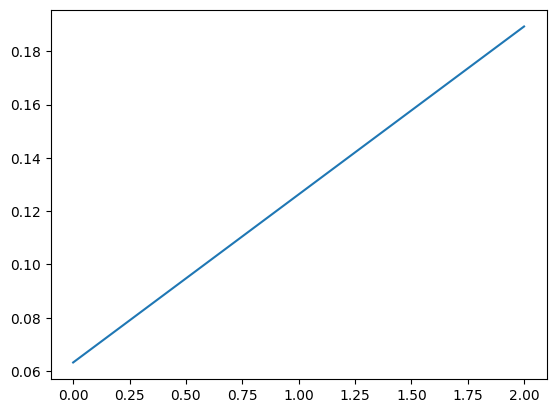

In [197]:
import numpy as np

#vamos a ver cuanta varianza queda explicada tras reducir a dos componentes
print(X_pca_3d.shape)
cumvar = np.cumsum(pca_3d.explained_variance_ratio_)
print(cumvar)
plt.plot(cumvar)

(10000, 15)
[0.06320773 0.12626964 0.18930941 0.25233961 0.31535243 0.37833255
 0.44128061 0.50420788 0.56710462 0.629968   0.69279826 0.75558899
 0.81835953 0.88101699 0.94360607]


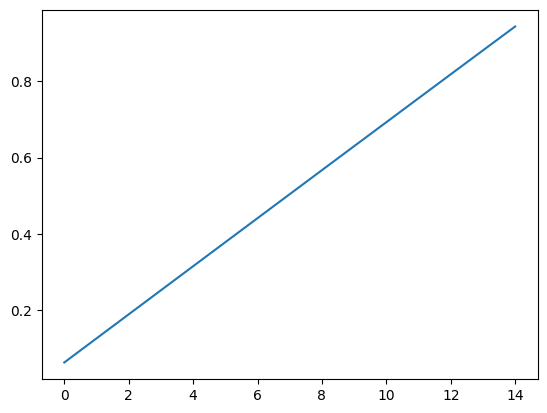

In [200]:
pca_15 = PCA(n_components=15)
X_pca_15 = pca_15.fit_transform(X_scaled)

print(X_pca_15.shape)
cumvar = np.cumsum(pca_15.explained_variance_ratio_)
print(cumvar)
plt.plot(cumvar)

Text(0, 0.5, 'Feature 1')

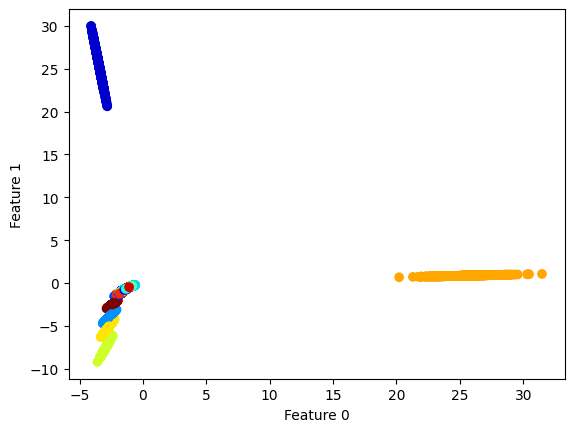

In [281]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=10, min_samples = 3)
clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, cmap='jet')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

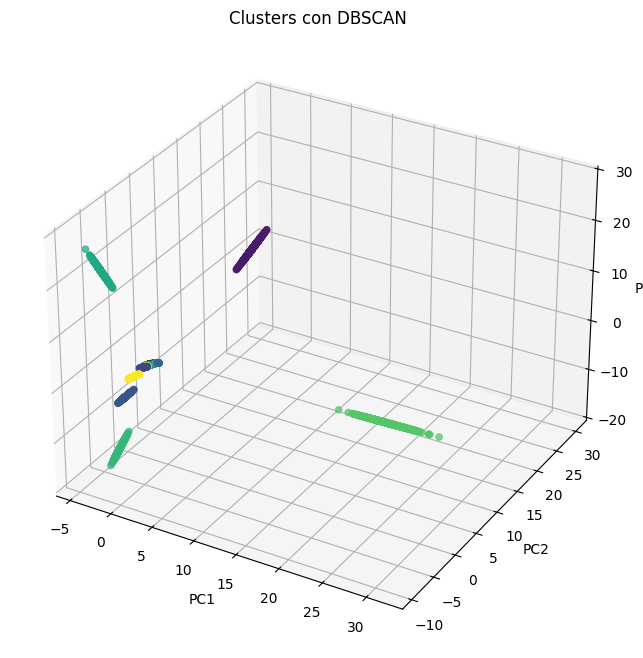

In [282]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=clusters, cmap='viridis', alpha=0.7)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Clusters con DBSCAN")

plt.show()

In [250]:
df_pivot['cluster']= clusters

In [251]:
df_pivot.groupby('cluster').count()

region     Baden-Württemberg                                              \
category Alcoholic Beverages                                               
product           Augustiner Bacardi Beck's Chardonnay Erdinger Weißbier   
cluster                                                                    
0                        605     605    605        605               605   
1                        636     636    636        636               636   
2                        617     617    617        617               617   
3                        626     626    626        626               626   
4                        637     637    637        637               637   
5                        633     633    633        633               633   
6                        608     608    608        608               608   
7                        608     608    608        608               608   
8                        613     613    613        613               613   
9                        641     641    641        641               641   
10                       630     630    630        630               630   
11                       671     671    671        671               671   
12                       593     593    593        593               593   
13                       632     632    632        632               632   
14                       606     606    606        606               606   
15                       644     644    644        644               644   

region                                                             ...  \
category                                                           ...   
product  Havana Club Jack Daniels Jever Johnnie Walker Krombacher  ...   
cluster                                                            ...   
0                605          605   605            605        605  ...   
1                636          636   636            636        636  ...   
2                617          617   617            617        617  ...   
3                626          626   626            626        626  ...   
4                637          637   637            637        637  ...   
5                633          633   633            633        633  ...   
6                608          608   608            608        608  ...   
7                608          608   608            608        608  ...   
8                613          613   613            613        613  ...   
9                641          641   641            641        641  ...   
10               630          630   630            630        630  ...   
11               671          671   671            671        671  ...   
12               593          593   593            593        593  ...   
13               632          632   632            632        632  ...   
14               606          606   606            606        606  ...   
15               644          644   644            644        644  ...   

region     Thüringen                                                        \
category Soft Drinks       Water                                             
product       Sprite Apollinaris Evian Gerolsteiner San Pellegrino Selters   
cluster                                                                      
0                605         605   605          605            605     605   
1                636         636   636          636            636     636   
2                617         617   617          617            617     617   
3                626         626   626          626            626     626   
4                637         637   637          637            637     637   
5                633         633   633          633            633     633   
6                608         608   608          608            608     608   
7                608         608   608          608            608     608   
8                613         613   613          613           

Como desde eps=10 hasta eps=30 se mantienen los 16 clusters, parece que se definen bien los grupos

In [252]:
from sklearn.metrics import silhouette_score

# Asegúrate de que no haya ruido (cluster -1)
silhouette = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette:.4f}")


Silhouette Score: 0.7590


In [254]:
df_pivot['cluster'].value_counts().sort_index()

cluster
0     605
1     636
2     617
3     626
4     637
5     633
6     608
7     608
8     613
9     641
10    630
11    671
12    593
13    632
14    606
15    644
Name: count, dtype: int64

In [260]:
# Aplanar columnas si df_pivot tiene columnas de múltiples niveles
if isinstance(df_pivot.columns, pd.MultiIndex):
    df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]



In [264]:
df_pivot = df_pivot.reset_index()


In [265]:
df_pivot

customer_id  Baden-Württemberg_Alcoholic Beverages_Augustiner  \
0           CUS1                                                 0   
1          CUS10                                                 0   
2         CUS100                                                 0   
3        CUS1000                                                 0   
4       CUS10000                                                 0   
...          ...                                               ...   
9995     CUS9995                                                 0   
9996     CUS9996                                                 0   
9997     CUS9997                                                 0   
9998     CUS9998                                                 0   
9999     CUS9999                                                 0   

      Baden-Württemberg_Alcoholic Beverages_Bacardi  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
9995                                              0   
9996                                              0   
9997                                              0   
9998                                              0   
9999                                              0   

      Baden-Württemberg_Alcoholic Beverages_Beck's  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
...                                            ...   
9995                                             0   
9996                                             0   
9997                                             0   
9998                                             0   
9999                                             0   

      Baden-Württemberg_Alcoholic Beverages_Chardonnay  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
9995                                                 0   
9996                                                 0   
9997                                                 0   
9998                                                 0   
9999                                                 0   

      Baden-Württemberg_Alcoholic Beverages_Erdinger Weißbier  \
0                                                     0         
1                                                     0         
2                                                     0         
3                                                     0         
4                                                     0         
...                                                 ...         
9995                                                  0         
9996                                                  0         
9997                                                  0         
9998                                                  0         
9999                                                  0         

      Baden-Württemberg_Alcoholic Beverages_Havana Club  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                   

In [266]:
df_pivot_with_cluster = df_pivot[['customer_id', 'cluster__']]
df = df.merge(df_pivot_with_cluster, on='customer_id', how='left')


In [270]:
df['cluster']=df['cluster__']
region_cluster_counts = pd.crosstab(df['region'], df['cluster'])
print(region_cluster_counts)


cluster                    0      1      2      3      4      5      6   \
region                                                                    
Baden-Württemberg           0      0      0      0      0      0      0   
Bayern                      0      0  28999      0      0      0      0   
Berlin                      0      0      0      0      0      0      0   
Brandenburg                 0      0      0      0      0      0      0   
Bremen                      0      0      0      0      0  29751      0   
Hamburg                     0      0      0      0      0      0      0   
Hessen                      0      0      0      0      0      0  28576   
Mecklenburg-Vorpommern  28435      0      0      0      0      0      0   
Niedersachsen               0      0      0      0      0      0      0   
Nordrhein-Westfalen         0      0      0      0      0      0      0   
Rheinland-Pfalz             0      0      0      0      0      0      0   
Saarland                 

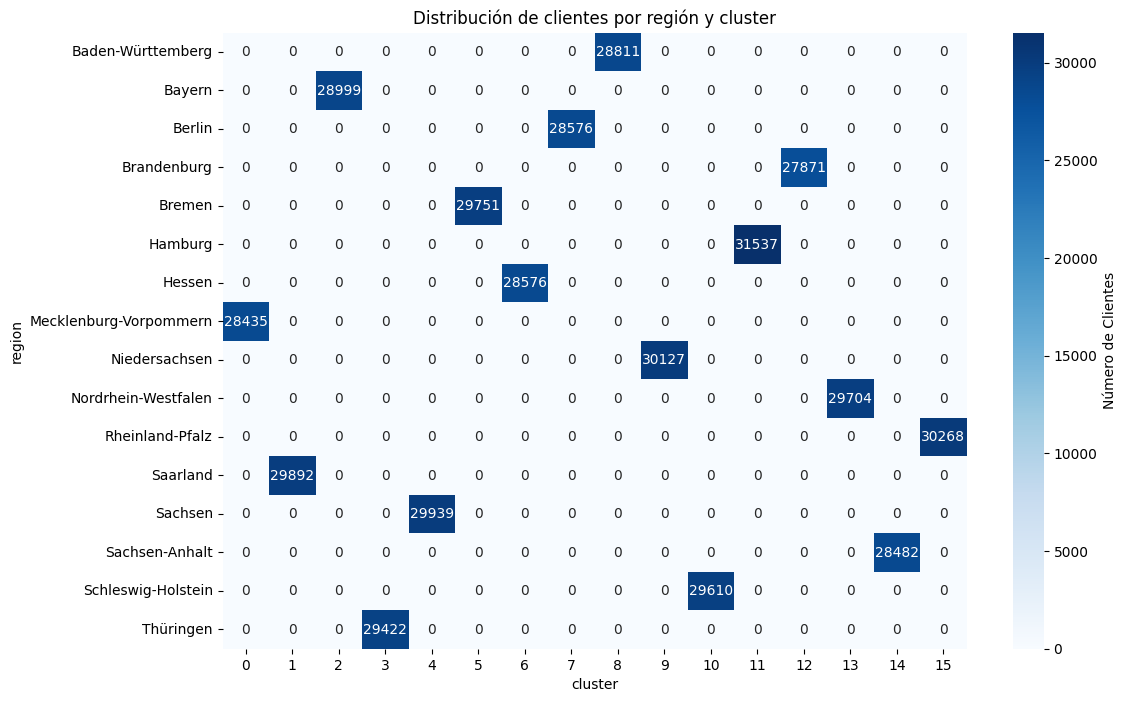

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tabla de calor de la distribución de clientes por región y cluster
plt.figure(figsize=(12, 8))
sns.heatmap(region_cluster_counts, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Número de Clientes'})
plt.title('Distribución de clientes por región y cluster')
plt.show()


In [273]:
len(df['region'].unique())

16

In [284]:
df_pivot

customer_id  Baden-Württemberg_Alcoholic Beverages_Augustiner  \
0           CUS1                                                 0   
1          CUS10                                                 0   
2         CUS100                                                 0   
3        CUS1000                                                 0   
4       CUS10000                                                 0   
...          ...                                               ...   
9995     CUS9995                                                 0   
9996     CUS9996                                                 0   
9997     CUS9997                                                 0   
9998     CUS9998                                                 0   
9999     CUS9999                                                 0   

      Baden-Württemberg_Alcoholic Beverages_Bacardi  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
9995                                              0   
9996                                              0   
9997                                              0   
9998                                              0   
9999                                              0   

      Baden-Württemberg_Alcoholic Beverages_Beck's  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
...                                            ...   
9995                                             0   
9996                                             0   
9997                                             0   
9998                                             0   
9999                                             0   

      Baden-Württemberg_Alcoholic Beverages_Chardonnay  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
9995                                                 0   
9996                                                 0   
9997                                                 0   
9998                                                 0   
9999                                                 0   

      Baden-Württemberg_Alcoholic Beverages_Erdinger Weißbier  \
0                                                     0         
1                                                     0         
2                                                     0         
3                                                     0         
4                                                     0         
...                                                 ...         
9995                                                  0         
9996                                                  0         
9997                                                  0         
9998                                                  0         
9999                                                  0         

      Baden-Württemberg_Alcoholic Beverages_Havana Club  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                   

## clustering cliente-producto

In [1]:
from sqlalchemy import create_engine
import pandas as pd

user = 'PERKYGENIUS27'
password = 'Sopomanitanio27'
account = 'bdfuagx-fv18223'
database = 'practicas_nubita'
schema = 'LND'
warehouse = 'COMPUTE_WH'

engine = create_engine(
    f'snowflake://{user}:{password}@{account}/{database}/{schema}?warehouse={warehouse}'
)

query = "SELECT * FROM LND.ods_cli_l6_v_beverage_sales_data_categorizados"

df = pd.read_sql(query, engine)

df

customer_id          product             category               region  \
0           CUS888           Merlot  Alcoholic Beverages  Nordrhein-Westfalen   
1          CUS1420   Moët & Chandon  Alcoholic Beverages              Hamburg   
2          CUS1916         Rockstar          Soft Drinks        Niedersachsen   
3          CUS9613        Mezzo Mix          Soft Drinks   Schleswig-Holstein   
4          CUS5672  Cranberry Juice               Juices            Thüringen   
...            ...              ...                  ...                  ...   
469995     CUS8920       Augustiner  Alcoholic Beverages       Sachsen-Anhalt   
469996      CUS782           Kölsch  Alcoholic Beverages            Thüringen   
469997     CUS7101       Augustiner  Alcoholic Beverages              Hamburg   
469998     CUS9207          Bacardi  Alcoholic Beverages      Rheinland-Pfalz   
469999     CUS9203         Riesling  Alcoholic Beverages            Thüringen   

        num_orders  total_quantity  total_spent  avg_unit_price  avg_discount  \
0               11             101       439.09        4.350000      0.000000   
1                9              99      5896.05       61.066667      0.000000   
2               11             509      1327.18        2.721818      0.100000   
3               18            1071      1083.79        1.072778      0.097222   
4               42            2185      6636.41        3.242381      0.082143   
...            ...             ...          ...             ...           ...   
469995           6              52        58.80        1.123333      0.000000   
469996           3              69        62.23        0.963333      0.066667   
469997           3             204       511.43        2.690000      0.083333   
469998           2              15       201.60       13.440000      0.000000   
469999           3              20        86.40        4.320000      0.000000   

       first_order_date last_order_date  num_lines  
0            2021-02-16      2023-10-09         11  
1            2021-02-10      2023-12-07          9  
2            2021-03-02      2023-12-04         11  
3            2021-02-09      2023-11-04         18  
4            2021-01-13      2023-12-20         42  
...                 ...             ...        ...  
469995       2021-05-26      2023-11-12          6  
469996       2021-02-11      2021-08-31          3  
469997       2021-01-30      2023-02-20          3  
469998       2021-03-24      2021-12-16          2  
469999       2023-04-09      2023-05-30          3  

[470000 rows x 12 columns]

In [2]:
!pip install category_encoders


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


#### Kmeans

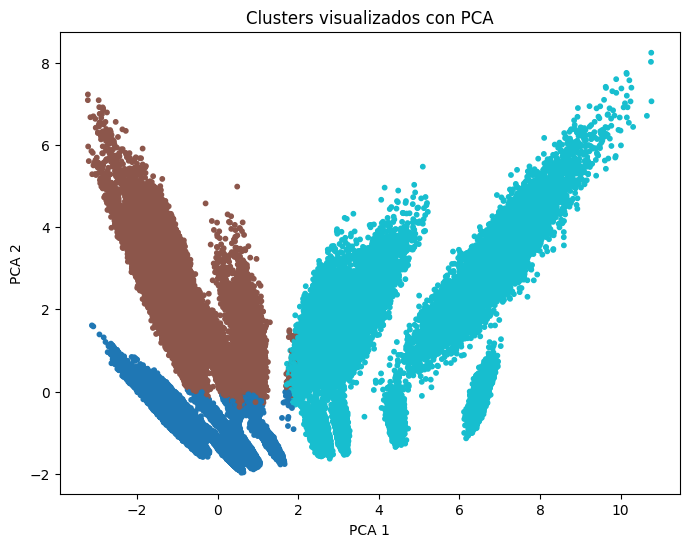

In [2]:
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# 1. Seleccionamos las columnas relevantes
features = ['region', 'category', 'product', 
            'num_orders', 'total_quantity', 
            'total_spent', 'avg_unit_price', 'avg_discount']

df_cluster = df[features].copy()

# 2. Codificación target de las variables categóricas
target_col = 'total_spent'
encoder = ce.TargetEncoder(cols=['region', 'category', 'product'])
df_encoded = encoder.fit_transform(df_cluster, df_cluster[target_col])

# 3. Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# 4. KMeans clustering (elige el número de clusters que te interese)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 5. Añadimos los resultados al dataframe original
df['cluster'] = clusters

# (Opcional) 6. Visualización rápida con PCA (si te interesa)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=clusters, cmap='tab10', s=10)
plt.title('Clusters visualizados con PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


(470000, 2)
[0.37909272 0.63482928]


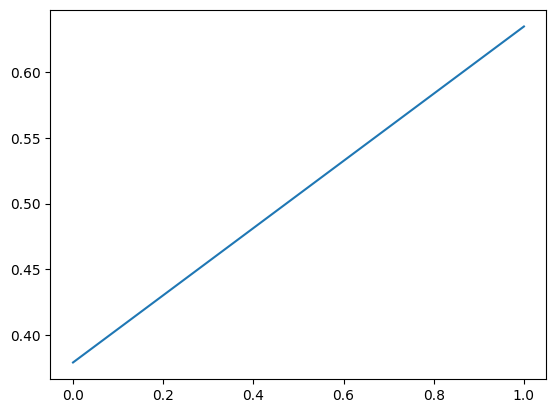

In [4]:
import numpy as np

#vamos a ver cuanta varianza queda explicada tras reducir a dos componentes
print(X_pca_2.shape)
cumvar = np.cumsum(pca_2.explained_variance_ratio_)
print(cumvar)
plt.plot(cumvar)

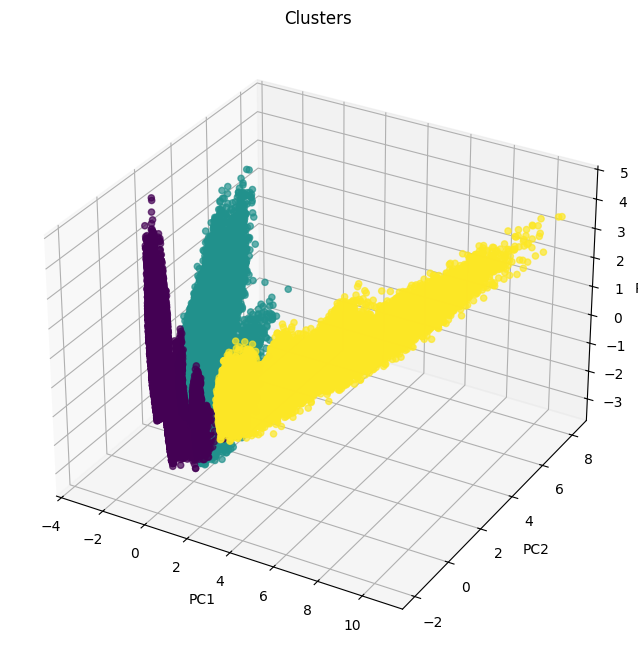

In [3]:
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=clusters, cmap='viridis', alpha=0.7)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Clusters")

plt.show()

(470000, 3)
[0.37909272 0.63482928 0.76449324]


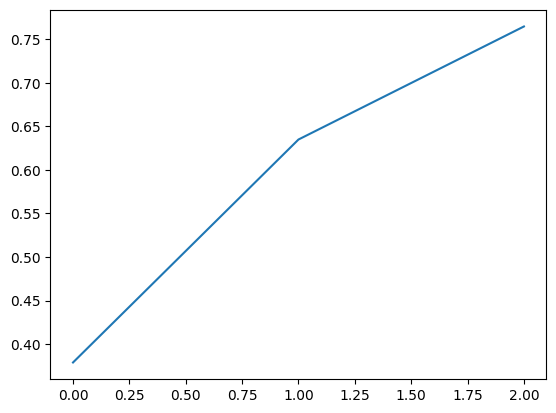

In [6]:
#vamos a ver cuanta varianza queda explicada tras reducir a dos componentes
print(X_pca_3.shape)
cumvar = np.cumsum(pca_3.explained_variance_ratio_)
print(cumvar)
plt.plot(cumvar)

In [7]:
from sklearn.metrics import silhouette_score
import numpy as np

# Por ejemplo, muestra del 10%
np.random.seed(42)
sample_size = int(0.1 * X_pca_3.shape[0])
sample_idx = np.random.choice(X_pca_3.shape[0], sample_size, replace=False)

silhouette = silhouette_score(X_pca_3[sample_idx], clusters[sample_idx])
print("Silhouette score sobre muestra del 10%:", silhouette)


Silhouette score sobre muestra del 10%: 0.47859556479475995


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Muestra del 10%
np.random.seed(42)
sample_idx = np.random.choice(X_pca_3.shape[0], int(0.1 * X_pca_3.shape[0]), replace=False)
X_sample = X_pca_3[sample_idx]

silhouettes = []
Ks = range(2, 21)

for k in Ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca_3)
    score = silhouette_score(X_sample, labels[sample_idx])  # solo usa muestra
    silhouettes.append(score)

# Visualización
plt.plot(Ks, silhouettes, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette score (10% sample)')
plt.grid(True)
plt.title('Silhouette vs. K')
plt.show()


KeyboardInterrupt: 

In [8]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

np.random.seed(42)
sample_size = int(0.1 * X_pca_3.shape[0])
sample_idx = np.random.choice(X_pca_3.shape[0], sample_size, replace=False)

silhouette = silhouette_score(X_pca_3[sample_idx], clusters[sample_idx])
print("Silhouette score sobre muestra del 10%:", silhouette)

Silhouette score sobre muestra del 10%: 0.5540661922544697


Lo que mejor ha salido son 5 clusters

In [9]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

df_pca = pd.DataFrame(X_pca_3, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = clusters
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color=df_pca['cluster'].astype(str))
fig.update_layout(title="PCA - 3D projection", margin=dict(l=0, r=0, b=0, t=30))
fig.write_html("pca_3d_plot.html")


No se ve buena separación con K-means

#### DBSCAN

In [29]:
from sklearn.cluster import DBSCAN

# Muestra el 5% para pruebas (23,500 puntos)
import numpy as np

np.random.seed(42)

sample_idx = np.random.choice(X_pca_3.shape[0], size=int(0.05 * X_pca_3.shape[0]), replace=False)
X_pca_sample = X_pca_3[sample_idx]

dbscan = DBSCAN(eps=0.42, min_samples = 4)
clusters = dbscan.fit_predict(X_pca_sample)


In [6]:
df_vis = pd.DataFrame(X_pca_sample, columns=['PC1', 'PC2', 'PC3'])
df_vis['cluster'] = clusters
df_vis.groupby('cluster').count()

PC1    PC2    PC3
cluster                     
-1          48     48     48
 0        7076   7076   7076
 1       12923  12923  12923
 2         881    881    881
 3         668    668    668
 4         331    331    331
 5         934    934    934
 6         330    330    330
 7         309    309    309

In [7]:
import plotly.express as px

fig = px.scatter_3d(df_vis, x='PC1', y='PC2', z='PC3', color=df_vis['cluster'].astype(str))
fig.show()

In [118]:
fig = px.scatter_3d(df_vis, x='PC1', y='PC2', z='PC3', color=df_vis['cluster'].astype(str))
fig.update_layout(title="PCA - 3D projection", margin=dict(l=0, r=0, b=0, t=30))
fig.write_html("pca_3d_plot.html")

#### HDBSCAN

In [8]:
!pip install hdbscan

  Using cached hdbscan-0.8.40.tar.gz (6.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.40-cp313-cp313-macosx_10_13_universal2.whl size=1369314 sha256=26a8aa542c99bbde456181b108489457e81038d918e227eb5859b059f6909b7e
  Stored in directory: /Users/davidcabreranoguera/Library/Caches/pip/wheels/c3/72/af/f4d00f372c844119d65a75541288c9a23c23696de08a71b7ec
Successfully built hdbscan

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [46]:
import hdbscan

hdbs = hdbscan.HDBSCAN(min_cluster_size=200)
clusters = hdbs.fit_predict(X_pca_sample)

/Users/davidcabreranoguera/Documents/repositorios/practicas-nubita/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/davidcabreranoguera/Documents/repositorios/practicas-nubita/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [47]:
df_vis = pd.DataFrame(X_pca_sample, columns=['PC1', 'PC2', 'PC3'])
df_vis['cluster'] = clusters
df_vis.groupby('cluster').count()

PC1   PC2   PC3
cluster                  
-1       2667  2667  2667
 0        308   308   308
 1        327   327   327
 2        928   928   928
 3        647   647   647
 4        620   620   620
 5       8885  8885  8885
 6       3615  3615  3615
 7       1326  1326  1326
 8       4177  4177  4177

In [48]:
import plotly.express as px

fig = px.scatter_3d(df_vis, x='PC1', y='PC2', z='PC3', color=df_vis['cluster'].astype(str))
fig.show()

#### GMM

##### Funciones

In [4]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    np.random.seed(42)
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='*', c='w', s=300, zorder=3)

In [5]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_ellipse_3d(position, covariance, ax=None, **kwargs):
    np.random.seed(42)
    """Dibuja un elipsoide 3D con una posición y covarianza"""
    ax = ax or plt.gca(projection='3d')

    # Convertir la covarianza en los ejes principales
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height, depth = 2 * np.sqrt(s)

    # Crear una malla 2D de valores u, v
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    u, v = np.meshgrid(u, v)

    # Parametrización de la superficie elipsoidal
    x = width * np.sin(v) * np.cos(u)
    y = height * np.sin(v) * np.sin(u)
    z = depth * np.cos(v)

    # Rotación de la elipse en 3D
    coords = np.array([x.flatten(), y.flatten(), z.flatten()])
    rot_coords = np.dot(Vt.T, coords).reshape(3, -1)

    # Ajustar la posición
    x_rot, y_rot, z_rot = rot_coords[0] + position[0], rot_coords[1] + position[1], rot_coords[2] + position[2]

    # Dibuja la superficie del elipsoide con transparencia
    x_rot = x_rot.reshape(x.shape)
    y_rot = y_rot.reshape(y.shape)
    z_rot = z_rot.reshape(z.shape)

    # Aquí eliminamos alpha de **kwargs y lo pasamos directamente
    ax.plot_surface(x_rot, y_rot, z_rot, color="b", rstride=5, cstride=5, alpha=0.3)

def plot_gmm_3d(gmm, X, label=True, ax=None):
    np.random.seed(42)
    """Visualizar los resultados del GMM con elipses 3D"""
    fig = plt.figure(figsize=(8, 8))
    ax = ax or fig.add_subplot(111, projection='3d')

    labels = gmm.fit(X).predict(X)

    # Si la etiqueta está activada, dibuja los puntos con colores según los clusters
    if label:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=40, zorder=2)

    # Dibujar las elipses 3D para cada componente
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse_3d(pos, covar, ax=ax, alpha=w * w_factor)

    # Dibujar los centroides
    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], gmm.means_[:, 2], marker='*', c='w', s=300, zorder=3)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("Clustering con GMM y Elipses 3D")

    plt.show()

In [6]:
import plotly.graph_objects as go

def draw_ellipse_3d_plotly(position, covariance):
    np.random.seed(42)
    """Dibuja un elipsoide 3D con posición y covarianza en un gráfico interactivo de Plotly"""
    # Convertir la covarianza a ejes principales
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height, depth = 2 * np.sqrt(s)

    # Crear malla de valores u, v
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    u, v = np.meshgrid(u, v)

    # Parametrización de la superficie elipsoidal
    x = width * np.sin(v) * np.cos(u)
    y = height * np.sin(v) * np.sin(u)
    z = depth * np.cos(v)

    # Rotación de la elipse en 3D
    coords = np.array([x.flatten(), y.flatten(), z.flatten()])
    rot_coords = np.dot(Vt.T, coords).reshape(3, -1)

    # Ajustar la posición
    x_rot, y_rot, z_rot = rot_coords[0] + position[0], rot_coords[1] + position[1], rot_coords[2] + position[2]

    # Devolver los valores de la superficie elipsoidal
    return x_rot, y_rot, z_rot

def plot_gmm_3d_plotly(gmm, X, label=True):
    np.random.seed(42)
    """Visualizar los resultados del GMM con elipses 3D en un gráfico interactivo de Plotly"""

    # Predecir las etiquetas
    labels = gmm.fit(X).predict(X)

    # Crear el gráfico de Plotly
    fig = go.Figure()

    # Agregar los puntos al gráfico 3D
    if label:
        fig.add_trace(go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                                 mode='markers', marker=dict(color=labels, size=5, opacity=0.8)))
    else:
        fig.add_trace(go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                                 mode='markers', marker=dict(size=5, opacity=0.8)))

    # Dibujar las elipses 3D
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        x_rot, y_rot, z_rot = draw_ellipse_3d_plotly(pos, covar)
        fig.add_trace(go.Mesh3d(x=x_rot, y=y_rot, z=z_rot, opacity=0.03, color='blue'))

    # Agregar los centroides
    fig.add_trace(go.Scatter3d(x=gmm.means_[:, 0], y=gmm.means_[:, 1], z=gmm.means_[:, 2],
                             mode='markers', marker=dict(symbol='diamond', size=12, color='white')))  # Cambié 'star' por 'diamond'

    # Configurar el diseño del gráfico
    fig.update_layout(
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        ),
        title="Clustering con GMM y Elipses 3D Interactivas",
        showlegend=False
    )

    # Mostrar el gráfico interactivo
    return fig

##### clustering

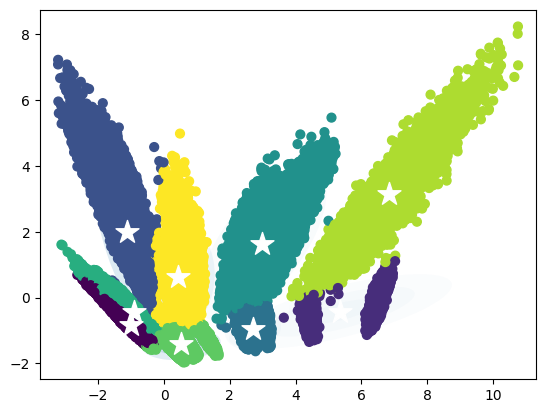

In [123]:
from sklearn.mixture import GaussianMixture

#visualizamos 2 clusters con la función 2d, utilizando los datos en 2 dimensiones
gmm_2 = GaussianMixture(n_components=9, random_state=42)
plot_gmm(gmm_2, X_pca_2)

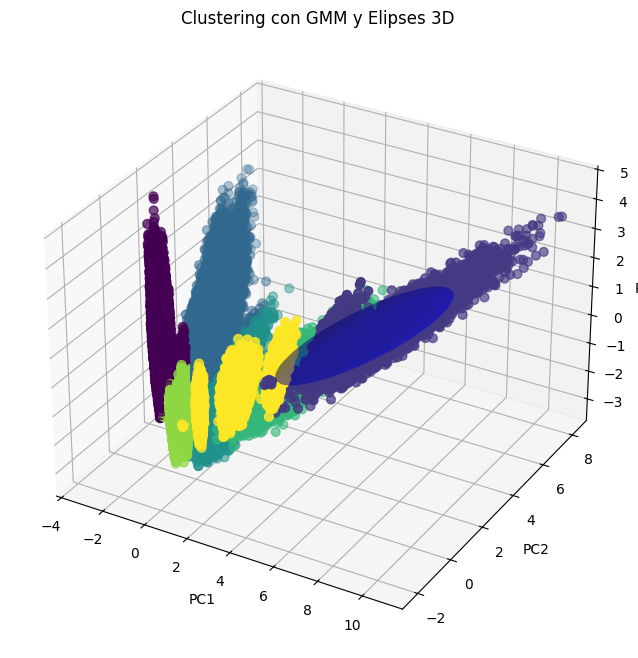

In [112]:
#hacemos lo mismo para 3d
plot_gmm_3d(gmm_2, X_pca_3)

In [124]:
fig = plot_gmm_3d_plotly(gmm_2, X_pca_3)
fig.write_html("pca_3d_plot.html")

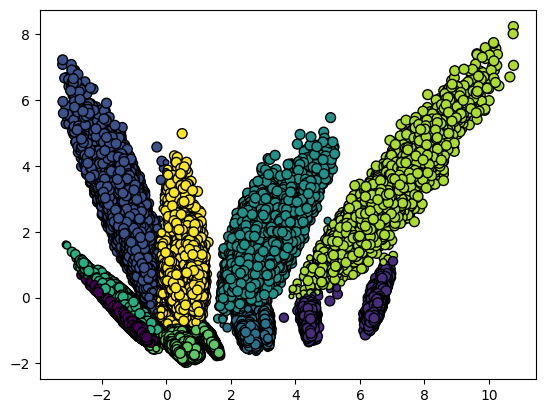

In [125]:
gmm_2 = GaussianMixture(n_components=9).fit(X_pca_2)
labels = gmm_2.predict(X_pca_2)

probs = gmm_2.predict_proba(X_pca_2)
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels, cmap='viridis', s=size, edgecolor='k');

Text(0.5, 0, 'n_components')

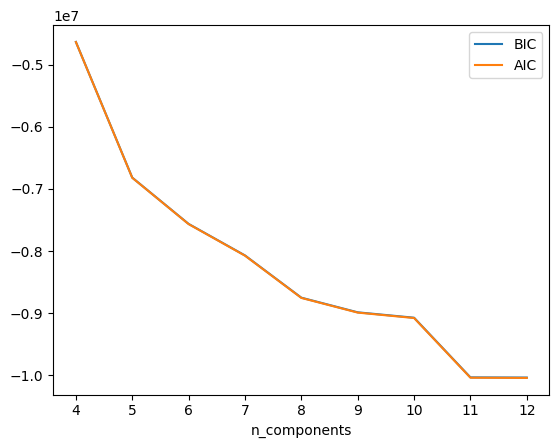

In [133]:
n_components = np.arange(4, 13)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(X_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

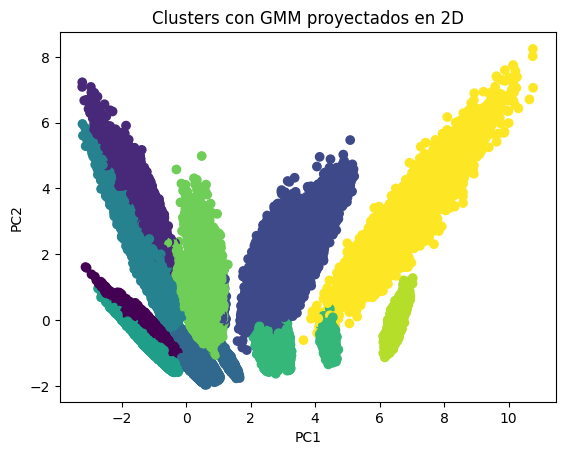

In [8]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=42)
clusters = gmm.fit_predict(X_scaled)

X_pca_gmm_2 = PCA(n_components=2).fit_transform(X_scaled)

plt.scatter(X_pca_gmm_2[:, 0], X_pca_gmm_2[:, 1], c=clusters)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters con GMM proyectados en 2D')
plt.show()


In [200]:
from sklearn.metrics import silhouette_score
import numpy as np

# Por ejemplo, muestra del 10%
np.random.seed(42)
sample_size = int(0.1 * X_scaled.shape[0])
sample_idx = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
X_sample = X_scaled[sample_idx]

silhouette = silhouette_score(X_sample, clusters[sample_idx])
print("Silhouette score sobre muestra del 10%:", silhouette)

Silhouette score sobre muestra del 10%: 0.331965238666238


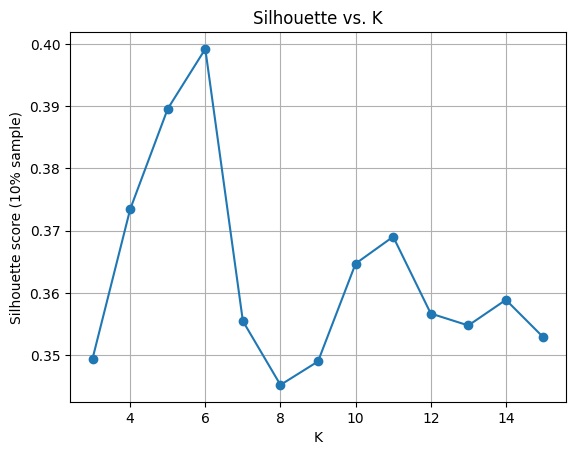

In [ ]:
silhouettes = []
Ks = range(3, 16)

for k in Ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_sample, labels[sample_idx])  # solo usa muestra
    silhouettes.append(score)

# Visualización
plt.plot(Ks, silhouettes, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette score (10% sample)')
plt.grid(True)
plt.title('Silhouette vs. K')
plt.show()

Aunque el mejor silhouette salga en 5, visualmente se ve mejor en 9 o 10

In [9]:
df['cluster'] = clusters

In [10]:
df['cluster'].value_counts().sort_index()

cluster
0     46015
1     25517
2     17908
3     89763
4     74446
5    134576
6     25748
7     42463
8      6437
9      7127
Name: count, dtype: int64

In [208]:
df

customer_id          product             category               region  \
0           CUS888           Merlot  Alcoholic Beverages  Nordrhein-Westfalen   
1          CUS1420   Moët & Chandon  Alcoholic Beverages              Hamburg   
2          CUS1916         Rockstar          Soft Drinks        Niedersachsen   
3          CUS9613        Mezzo Mix          Soft Drinks   Schleswig-Holstein   
4          CUS5672  Cranberry Juice               Juices            Thüringen   
...            ...              ...                  ...                  ...   
469995     CUS8920       Augustiner  Alcoholic Beverages       Sachsen-Anhalt   
469996      CUS782           Kölsch  Alcoholic Beverages            Thüringen   
469997     CUS7101       Augustiner  Alcoholic Beverages              Hamburg   
469998     CUS9207          Bacardi  Alcoholic Beverages      Rheinland-Pfalz   
469999     CUS9203         Riesling  Alcoholic Beverages            Thüringen   

        num_orders  total_quantity  total_spent  avg_unit_price  avg_discount  \
0               11             101       439.09        4.350000      0.000000   
1                9              99      5896.05       61.066667      0.000000   
2               11             509      1327.18        2.721818      0.100000   
3               18            1071      1083.79        1.072778      0.097222   
4               42            2185      6636.41        3.242381      0.082143   
...            ...             ...          ...             ...           ...   
469995           6              52        58.80        1.123333      0.000000   
469996           3              69        62.23        0.963333      0.066667   
469997           3             204       511.43        2.690000      0.083333   
469998           2              15       201.60       13.440000      0.000000   
469999           3              20        86.40        4.320000      0.000000   

       first_order_date last_order_date  num_lines  cluster  
0            2021-02-16      2023-10-09         11        3  
1            2021-02-10      2023-12-07          9        6  
2            2021-03-02      2023-12-04         11        4  
3            2021-02-09      2023-11-04         18        4  
4            2021-01-13      2023-12-20         42        1  
...                 ...             ...        ...      ...  
469995       2021-05-26      2023-11-12          6        3  
469996       2021-02-11      2021-08-31          3        7  
469997       2021-01-30      2023-02-20          3        7  
469998       2021-03-24      2021-12-16          2        3  
469999       2023-04-09      2023-05-30          3        3  

[470000 rows x 13 columns]

In [31]:
# Ver cuántos clusters distintos tiene cada customer_id en df
clusters_por_cliente = df.groupby('customer_id')['cluster'].nunique()

print(clusters_por_cliente[clusters_por_cliente > 1])


customer_id
CUS1        5
CUS10       5
CUS100      5
CUS1000     5
CUS10000    5
           ..
CUS9995     5
CUS9996     5
CUS9997     5
CUS9998     5
CUS9999     5
Name: cluster, Length: 10000, dtype: int64


In [209]:
df.groupby('cluster').agg({
    'region': pd.Series.mode,
    'product': pd.Series.mode,
    'category': pd.Series.mode,
    'num_orders': ['mean', 'std'],
    'total_quantity': ['mean', 'std'],
    'total_spent': ['mean', 'std'],
    'avg_unit_price': ['mean', 'std'],
    'avg_discount': ['mean', 'std'],
    'total_quantity': ['mean', 'std']
})

region                                            product  \
                  mode                                               mode   
cluster                                                                     
0               Bremen  [Cranberry Juice, Granini Apple, Hohes C Orang...   
1              Hamburg  [Cranberry Juice, Granini Apple, Hohes C Orang...   
2              Hamburg    [Bacardi, Havana Club, Jack Daniels, Tanqueray]   
3        Niedersachsen  [Augustiner, Bacardi, Chardonnay, Erdinger Wei...   
4               Hessen  [Apollinaris, Club Mate, Coca-Cola, Evian, Fan...   
5        Niedersachsen  [Apollinaris, Club Mate, Coca-Cola, Evian, Fan...   
6        Niedersachsen  [Jack Daniels, Johnnie Walker, Moët & Chandon,...   
7              Hamburg  [Augustiner, Erdinger Weißbier, Jever, Krombac...   
8        Niedersachsen                                     Veuve Clicquot   
9              Hamburg                   [Moët & Chandon, Veuve Clicquot]   

                    category num_orders           total_quantity              \
                        mode       mean       std           mean         std   
cluster                                                                        
0                     Juices  32.581875  6.543005     260.771640   57.881733   
1                     Juices  32.540463  6.568025    1644.533487  369.885816   
2        Alcoholic Beverages  11.467556  3.395227     578.737771  197.013775   
3        Alcoholic Beverages  11.806212  3.926402      94.470272   34.728285   
4                Soft Drinks  21.265602  6.303216    1073.996158  345.262938   
5                Soft Drinks  21.290572  6.277792     170.209034   53.997651   
6        Alcoholic Beverages  11.536663  3.411308      92.411255   30.905673   
7        Alcoholic Beverages  11.873278  4.000975     600.120670  225.630815   
8        Alcoholic Beverages  11.518254  3.413613      92.553363   30.787961   
9        Alcoholic Beverages  11.434685  3.443285     577.426407  198.964817   

          total_spent               avg_unit_price            avg_discount  \
                 mean           std           mean        std         mean   
cluster                                                                      
0          695.901207    226.710411       2.688594   0.716606     0.000000   
1         4111.256587   1175.369013       2.608684   0.530114     0.083524   
2        17203.798779   7028.937689      30.052827   5.977358     0.083519   
3          454.939910    453.905867       4.836428   4.291794     0.000000   
4         1337.816579    687.396414       1.334931   0.694622     0.083475   
5          218.053432    118.316959       1.334724   0.704497     0.000000   
6         4186.919858   1721.189261      45.325361  10.332282     0.000000   
7         2636.399548   2438.250017       4.398253   3.374777     0.083476   
8        10106.154232   3364.170170     109.192049   0.824313     0.000000   
9        38877.861987  14827.952298      66.952563   8.506540     0.083573   

                   
              std  
cluster            
0        0.000000  
1        0.006025  
2        0.010465  
3        0.000000  
4        0.007751  
5        0.000000  
6        0.000000  
7        0.010399  
8        0.000000  
9        0.010468

## Unimos l7 a la clusterización

In [11]:
from sqlalchemy import create_engine
import pandas as pd

user = 'PERKYGENIUS27'
password = 'Sopomanitanio27'
account = 'bdfuagx-fv18223'
database = 'practicas_nubita'
schema = 'LND'
warehouse = 'COMPUTE_WH'

engine = create_engine(
    f'snowflake://{user}:{password}@{account}/{database}/{schema}?warehouse={warehouse}'
)

query = "SELECT * FROM LND.ods_cli_l7_v_beverage_sales_data_categorizados"

df_l7 = pd.read_sql(query, engine)

df_l7

customer_id            product_a       product_b  cooccurrence_count
0           CUS9396        Granini Apple          Vittel                   4
1            CUS897           Fritz-Kola  Johnnie Walker                   1
2           CUS2878        Granini Apple      Vio Wasser                   3
3           CUS5209  Passion Fruit Juice    Volvic Touch                   6
4           CUS6940            Coca-Cola         Selters                   3
...             ...                  ...             ...                 ...
6579339     CUS2197          Havana Club  Moët & Chandon                   1
6579340     CUS9374     Rotkäppchen Sekt    Tomato Juice                   1
6579341     CUS3905                Jever      Vio Wasser                   1
6579342      CUS398        Granini Apple  Johnnie Walker                   1
6579343     CUS5366       Johnnie Walker    Tomato Juice                   1

[6579344 rows x 4 columns]

In [47]:
df_l7_filtrado = df_l7[df_l7['cooccurrence_count']>2]
df_l7_filtrado.shape

(1350633, 4)

In [18]:
df_l7_filtrado.head()

customer_id            product_a       product_b  cooccurrence_count
0     CUS9396        Granini Apple          Vittel                   4
2     CUS2878        Granini Apple      Vio Wasser                   3
3     CUS5209  Passion Fruit Juice    Volvic Touch                   6
4     CUS6940            Coca-Cola         Selters                   3
5     CUS5251    Erdinger Weißbier  Hohes C Orange                   3

In [48]:
pares_unicos = df_l7_filtrado[['product_a', 'product_b']].drop_duplicates()
pares_unicos

product_a       product_b
0             Granini Apple          Vittel
2             Granini Apple      Vio Wasser
3       Passion Fruit Juice    Volvic Touch
4                 Coca-Cola         Selters
5         Erdinger Weißbier  Hohes C Orange
...                     ...             ...
168699         Jack Daniels  Moët & Chandon
171325         Jack Daniels          Merlot
181049              Bacardi  Johnnie Walker
200014       Johnnie Walker          Merlot
282995           Chardonnay     Havana Club

[1081 rows x 2 columns]

In [15]:
# Paso 1: Unimos el cluster a la tabla de coocurrencias
l7_clustered = df_l7_filtrado.merge(df[['customer_id', 'cluster']], on='customer_id', how='left')

# Paso 2: Agrupamos por cluster y par de productos
cooccurrence_by_cluster = (
    l7_clustered
    .groupby(['cluster', 'product_a', 'product_b'])['cooccurrence_count']
    .sum()
    .reset_index()
    .sort_values(['cluster', 'cooccurrence_count'], ascending=[True, False])
)

# Paso 3: Opcional – Top 10 combinaciones por cluster
top_n_per_cluster = (
    cooccurrence_by_cluster
    .groupby('cluster')
    .head(10)
)

# Mostrar
for cluster_id in sorted(top_n_per_cluster['cluster'].unique()):
    print(f"\n🔹 Top coocurrencias en cluster {cluster_id}")
    display(top_n_per_cluster[top_n_per_cluster['cluster'] == cluster_id])



🔹 Top coocurrencias en cluster 0


cluster        product_a            product_b  cooccurrence_count
308        0  Cranberry Juice       Hohes C Orange              152888
590        0   Hohes C Orange          Mango Juice              152104
521        0    Granini Apple       Hohes C Orange              151926
598        0   Hohes C Orange   Rauch Multivitamin              149955
609        0   Hohes C Orange         Tomato Juice              149918
596        0   Hohes C Orange  Passion Fruit Juice              149404
322        0  Cranberry Juice   Rauch Multivitamin              141344
306        0  Cranberry Juice        Granini Apple              141222
527        0    Granini Apple          Mango Juice              141188
320        0  Cranberry Juice  Passion Fruit Juice              141089


🔹 Top coocurrencias en cluster 1


cluster           product_a            product_b  cooccurrence_count
1671        1      Hohes C Orange          Mango Juice               83842
1602        1       Granini Apple       Hohes C Orange               83640
1690        1      Hohes C Orange         Tomato Juice               83608
1679        1      Hohes C Orange   Rauch Multivitamin               81860
1677        1      Hohes C Orange  Passion Fruit Juice               81750
1389        1     Cranberry Juice       Hohes C Orange               81721
1401        1     Cranberry Juice  Passion Fruit Juice               79278
1842        1         Mango Juice  Passion Fruit Juice               78753
1855        1         Mango Juice         Tomato Juice               78346
2019        1  Rauch Multivitamin         Tomato Juice               78129


🔹 Top coocurrencias en cluster 2


cluster           product_a            product_b  cooccurrence_count
2752        2      Hohes C Orange          Mango Juice               58912
2683        2       Granini Apple       Hohes C Orange               58731
2771        2      Hohes C Orange         Tomato Juice               58696
2470        2     Cranberry Juice       Hohes C Orange               57497
2760        2      Hohes C Orange   Rauch Multivitamin               57492
2758        2      Hohes C Orange  Passion Fruit Juice               57386
2482        2     Cranberry Juice  Passion Fruit Juice               55583
2923        2         Mango Juice  Passion Fruit Juice               55223
2936        2         Mango Juice         Tomato Juice               54955
3100        2  Rauch Multivitamin         Tomato Juice               54848


🔹 Top coocurrencias en cluster 3


cluster        product_a            product_b  cooccurrence_count
3551        3  Cranberry Juice       Hohes C Orange              298505
3833        3   Hohes C Orange          Mango Juice              297103
3764        3    Granini Apple       Hohes C Orange              296853
3852        3   Hohes C Orange         Tomato Juice              292972
3841        3   Hohes C Orange   Rauch Multivitamin              292841
3839        3   Hohes C Orange  Passion Fruit Juice              292085
3565        3  Cranberry Juice   Rauch Multivitamin              275509
3770        3    Granini Apple          Mango Juice              275208
3549        3  Cranberry Juice        Granini Apple              275138
3563        3  Cranberry Juice  Passion Fruit Juice              275068


🔹 Top coocurrencias en cluster 4


cluster           product_a            product_b  cooccurrence_count
4914        4      Hohes C Orange          Mango Juice              244841
4933        4      Hohes C Orange         Tomato Juice              244274
4845        4       Granini Apple       Hohes C Orange              244187
4632        4     Cranberry Juice       Hohes C Orange              239079
4922        4      Hohes C Orange   Rauch Multivitamin              239021
4920        4      Hohes C Orange  Passion Fruit Juice              238765
4644        4     Cranberry Juice  Passion Fruit Juice              231006
5085        4         Mango Juice  Passion Fruit Juice              229573
5098        4         Mango Juice         Tomato Juice              228277
5262        4  Rauch Multivitamin         Tomato Juice              227848


🔹 Top coocurrencias en cluster 5


cluster        product_a            product_b  cooccurrence_count
5713        5  Cranberry Juice       Hohes C Orange              447407
5995        5   Hohes C Orange          Mango Juice              445393
5926        5    Granini Apple       Hohes C Orange              445107
6014        5   Hohes C Orange         Tomato Juice              439068
6003        5   Hohes C Orange   Rauch Multivitamin              439036
6001        5   Hohes C Orange  Passion Fruit Juice              437907
5727        5  Cranberry Juice   Rauch Multivitamin              413025
5932        5    Granini Apple          Mango Juice              412768
5711        5  Cranberry Juice        Granini Apple              412468
5725        5  Cranberry Juice  Passion Fruit Juice              412419


🔹 Top coocurrencias en cluster 6


cluster        product_a            product_b  cooccurrence_count
6794        6  Cranberry Juice       Hohes C Orange               85600
7076        6   Hohes C Orange          Mango Juice               85200
7007        6    Granini Apple       Hohes C Orange               85132
7095        6   Hohes C Orange         Tomato Juice               83996
7084        6   Hohes C Orange   Rauch Multivitamin               83984
7082        6   Hohes C Orange  Passion Fruit Juice               83752
6808        6  Cranberry Juice   Rauch Multivitamin               79036
7013        6    Granini Apple          Mango Juice               78968
6792        6  Cranberry Juice        Granini Apple               78936
6806        6  Cranberry Juice  Passion Fruit Juice               78912


🔹 Top coocurrencias en cluster 7


cluster           product_a            product_b  cooccurrence_count
8157        7      Hohes C Orange          Mango Juice              139670
8088        7       Granini Apple       Hohes C Orange              139312
8176        7      Hohes C Orange         Tomato Juice              139289
7875        7     Cranberry Juice       Hohes C Orange              136363
8165        7      Hohes C Orange   Rauch Multivitamin              136337
8163        7      Hohes C Orange  Passion Fruit Juice              136219
7887        7     Cranberry Juice  Passion Fruit Juice              131782
8328        7         Mango Juice  Passion Fruit Juice              130952
8341        7         Mango Juice         Tomato Juice              130137
8505        7  Rauch Multivitamin         Tomato Juice              129895


🔹 Top coocurrencias en cluster 8


cluster        product_a            product_b  cooccurrence_count
8956        8  Cranberry Juice       Hohes C Orange               21400
9238        8   Hohes C Orange          Mango Juice               21300
9169        8    Granini Apple       Hohes C Orange               21283
9257        8   Hohes C Orange         Tomato Juice               20999
9246        8   Hohes C Orange   Rauch Multivitamin               20996
9244        8   Hohes C Orange  Passion Fruit Juice               20938
8970        8  Cranberry Juice   Rauch Multivitamin               19759
9175        8    Granini Apple          Mango Juice               19742
8954        8  Cranberry Juice        Granini Apple               19734
8968        8  Cranberry Juice  Passion Fruit Juice               19728


🔹 Top coocurrencias en cluster 9


cluster           product_a            product_b  cooccurrence_count
10319        9      Hohes C Orange          Mango Juice               23434
10338        9      Hohes C Orange         Tomato Juice               23375
10250        9       Granini Apple       Hohes C Orange               23372
10037        9     Cranberry Juice       Hohes C Orange               22879
10327        9      Hohes C Orange   Rauch Multivitamin               22876
10325        9      Hohes C Orange  Passion Fruit Juice               22855
10049        9     Cranberry Juice  Passion Fruit Juice               22124
10490        9         Mango Juice  Passion Fruit Juice               21982
10503        9         Mango Juice         Tomato Juice               21854
10667        9  Rauch Multivitamin         Tomato Juice               21815

In [19]:
l7_clustered.head()

customer_id      product_a product_b  cooccurrence_count  cluster
0     CUS9396  Granini Apple    Vittel                   4        0
1     CUS9396  Granini Apple    Vittel                   4        0
2     CUS9396  Granini Apple    Vittel                   4        5
3     CUS9396  Granini Apple    Vittel                   4        0
4     CUS9396  Granini Apple    Vittel                   4        5

# clustering a nivel de cliente

In [36]:
sitios_por_cliente = df.groupby('customer_id')['region'].nunique()
print(sitios_por_cliente[sitios_por_cliente > 1])

Series([], Name: region, dtype: int64)


In [40]:
import pandas as pd

# Crear variables por producto: suma total comprada por cliente
productos_por_cliente = df.groupby(['customer_id', 'product'])['total_quantity'].sum().unstack(fill_value=0)

# Similar para categorías
categorias_por_cliente = df.groupby(['customer_id', 'category'])['total_quantity'].sum().unstack(fill_value=0)

# Similar para regiones
regiones_por_cliente = df.groupby(['customer_id', 'region'])['total_quantity'].sum().unstack(fill_value=0)

# Combinar todo en un solo dataframe
cliente_features = pd.concat([productos_por_cliente, categorias_por_cliente, regiones_por_cliente], axis=1)

agregado_cliente = df.groupby('customer_id').agg({
    'num_orders': 'sum',           # total pedidos por cliente
    'total_quantity': 'sum',       # cantidad total comprada
    'total_spent': 'sum',          # gasto total
    'avg_unit_price': 'mean',      # precio unitario promedio
    'avg_discount': 'mean'         # descuento promedio
})

cliente_features = cliente_features.merge(agregado_cliente, left_index=True, right_index=True, how='left')

In [41]:
cliente_features

Apollinaris  Augustiner  Bacardi  Beck's  Chardonnay  Club Mate  \
customer_id                                                                    
CUS1                 208         118       94      57          58        196   
CUS10                254          66       90      89          77        132   
CUS100               179         112       72     223          57         71   
CUS1000              797         863      313     750         482       1402   
CUS10000             936         318      718     617         416        904   
...                  ...         ...      ...     ...         ...        ...   
CUS9995              163          36       80     110         119        170   
CUS9996              183          71      119     103          83        163   
CUS9997              144          78      113      76          88         87   
CUS9998              214          75       53      73         116        109   
CUS9999             1237         385      593     504         705        934   

             Coca-Cola  Cranberry Juice  Erdinger Weißbier  Evian  ...  \
customer_id                                                        ...   
CUS1               177              192                 56    272  ...   
CUS10              134              239                 81    260  ...   
CUS100             178              275                123    165  ...   
CUS1000            774             1958                631   1430  ...   
CUS10000           862             1960                338   1133  ...   
...                ...              ...                ...    ...  ...   
CUS9995            133              325                133    219  ...   
CUS9996            161              238                138    183  ...   
CUS9997            109              262                132    258  ...   
CUS9998            170              237                 53    192  ...   
CUS9999            685             1313                849   1038  ...   

             Saarland  Sachsen  Sachsen-Anhalt  Schleswig-Holstein  Thüringen  \
customer_id                                                                     
CUS1                0        0               0                   0          0   
CUS10            6910        0               0                   0          0   
CUS100              0        0               0                   0          0   
CUS1000             0        0               0                   0      44318   
CUS10000            0    46184               0                   0          0   
...               ...      ...             ...                 ...        ...   
CUS9995             0        0               0                   0          0   
CUS9996             0     7354               0                   0          0   
CUS9997             0        0               0                   0          0   
CUS9998             0        0            7276                   0          0   
CUS9999             0        0               0               41960          0   

             num_orders  total_quantity  total_spent  avg_unit_price  \
customer_id                                                            
CUS1                929            7508     38904.13        8.621288   
CUS10               872            6910     40288.83        8.626178   
CUS100              895            7163     36039.74        8.537570   
CUS1000             881           44318    271186.90        8.458529   
CUS10000            929           46184    253436.72        7.760276   
...                 ...             ...          ...             ...   
CUS9995             907            7055     47795.78        8.630173   
CUS9996             908            7354     49415.23        8.577250   
CUS9997             907            7170     41464.55        8.567787   
CUS9998             898            7276     44431.73        8.670400   
CUS9999             839           41960    253245.61        8.041366   

             avg_d

In [53]:
top_pares = df_l7.groupby(['product_a', 'product_b'])['cooccurrence_count'].sum().sort_values(ascending=False).head(10)
# Reiniciar índice para trabajar con las columnas
top_pares_df = top_pares.reset_index()
top_pares_df['pair'] = top_pares_df['product_a'] + ' & ' + top_pares_df['product_b']

# Lista de tuplas con los top 15 pares
top_pair_tuples = list(zip(top_pares_df['product_a'], top_pares_df['product_b']))

# Crear columna de par
df_l7['pair'] = df_l7['product_a'] + ' & ' + df_l7['product_b']

# Filtrar solo a los pares relevantes
df_top_pairs = df_l7[df_l7[['product_a', 'product_b']].apply(tuple, axis=1).isin(top_pair_tuples)]

# Agrupar por cliente y par
cliente_par_counts = (
    df_top_pairs.groupby(['customer_id', 'pair'])['cooccurrence_count']
    .sum()
    .unstack(fill_value=0)
)

cliente_features = cliente_features.merge(cliente_par_counts, on='customer_id', how='left')

# Reemplazar posibles NaNs por 0
cliente_features.fillna(0, inplace=True)


In [54]:
cliente_features

Apollinaris  Augustiner  Bacardi  Beck's  Chardonnay  Club Mate  \
customer_id                                                                    
CUS1                 208         118       94      57          58        196   
CUS10                254          66       90      89          77        132   
CUS100               179         112       72     223          57         71   
CUS1000              797         863      313     750         482       1402   
CUS10000             936         318      718     617         416        904   
...                  ...         ...      ...     ...         ...        ...   
CUS9995              163          36       80     110         119        170   
CUS9996              183          71      119     103          83        163   
CUS9997              144          78      113      76          88         87   
CUS9998              214          75       53      73         116        109   
CUS9999             1237         385      593     504         705        934   

             Coca-Cola  Cranberry Juice  Erdinger Weißbier  Evian  ...  \
customer_id                                                        ...   
CUS1               177              192                 56    272  ...   
CUS10              134              239                 81    260  ...   
CUS100             178              275                123    165  ...   
CUS1000            774             1958                631   1430  ...   
CUS10000           862             1960                338   1133  ...   
...                ...              ...                ...    ...  ...   
CUS9995            133              325                133    219  ...   
CUS9996            161              238                138    183  ...   
CUS9997            109              262                132    258  ...   
CUS9998            170              237                 53    192  ...   
CUS9999            685             1313                849   1038  ...   

             Cranberry Juice & Hohes C Orange  \
customer_id                                     
CUS1                                        6   
CUS10                                       2   
CUS100                                      6   
CUS1000                                     8   
CUS10000                                    2   
...                                       ...   
CUS9995                                     6   
CUS9996                                     3   
CUS9997                                     0   
CUS9998                                     2   
CUS9999                                     3   

             Cranberry Juice & Passion Fruit Juice  \
customer_id                                          
CUS1                                             2   
CUS10                                            3   
CUS100                                           2   
CUS1000                                          2   
CUS10000                                         4   
...                                            ...   
CUS9995                                          2   
CUS9996                                          3   
CUS9997                                          5   
CUS9998                                          4   
CUS9999                                          4   

             Cranberry Juice & Rauch Multivitamin  \
customer_id                                         
CUS1                                            4   
CUS10                                           3   
CUS100                                          6   
CUS1000                                         2   
CUS10000                                        3   
...                                           ...   
CUS9995                                         4   
CUS9996                                         6   
CUS9997                                         3   
CUS9998                                         1   
CUS9999                         

### kmeans

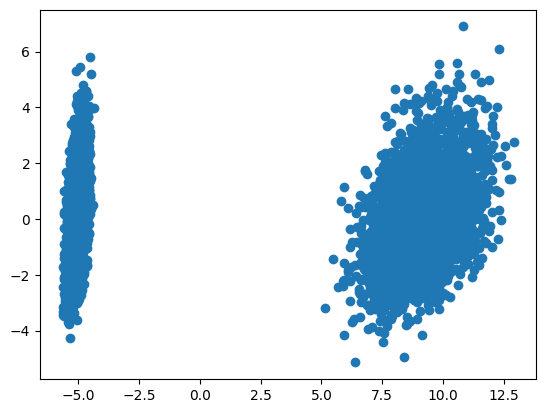

In [55]:
# 3. Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cliente_features)

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.scatter(X_pca_2[:,0], X_pca_2[:,1])

In [62]:
import numpy as np

#vamos a ver cuanta varianza queda explicada tras reducir a dos componentes
print(X_pca_2.shape)
cumvar = np.cumsum(pca_2.explained_variance_ratio_)
print(cumvar)

(10000, 2)
[0.56849377 0.5928151 ]


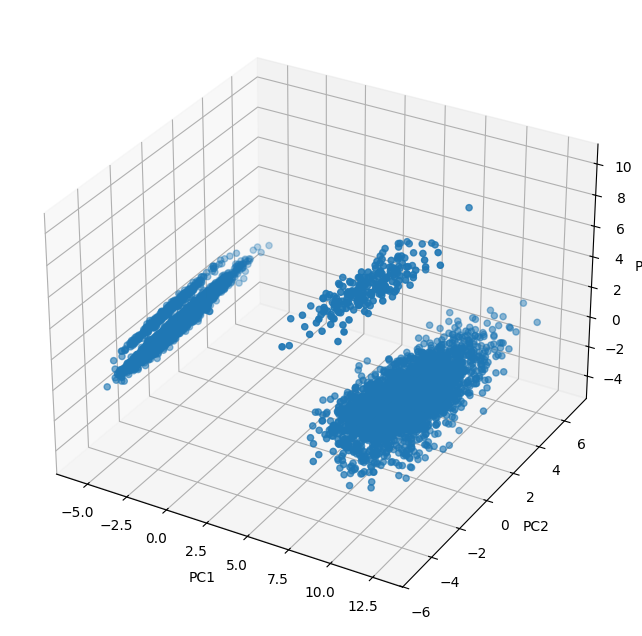

In [59]:
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2])

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()

In [61]:
import numpy as np

#vamos a ver cuanta varianza queda explicada tras reducir a dos componentes
print(X_pca_3.shape)
cumvar = np.cumsum(pca_3.explained_variance_ratio_)
print(cumvar)

(10000, 3)
[0.56849377 0.5928151  0.61562815]


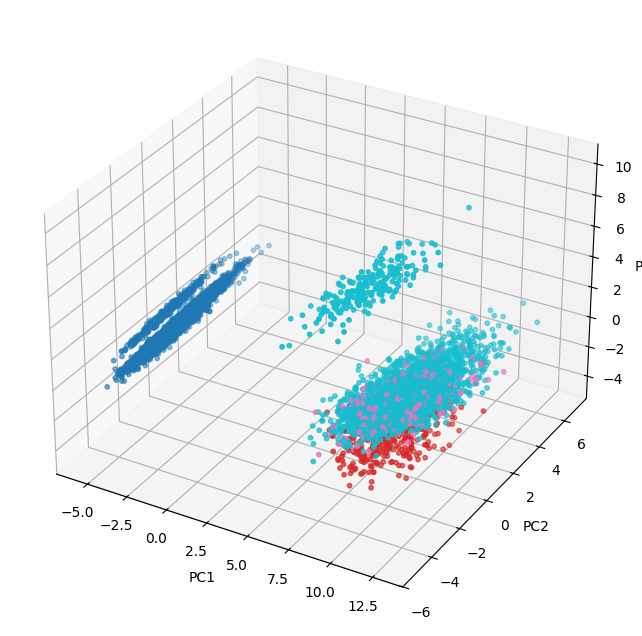

In [78]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=clusters, cmap='tab10', s=10)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()

In [73]:
import plotly.express as px
import pandas as pd

# Suponiendo que X_pca_3 es un numpy array con las 3 componentes
df_pca = pd.DataFrame({
    'PC1': X_pca_3[:, 0],
    'PC2': X_pca_3[:, 1],
    'PC3': X_pca_3[:, 2],
    'cluster': clusters
})

fig = px.scatter_3d(
    df_pca,
    x='PC1',
    y='PC2',
    z='PC3',
    color='cluster',
    color_continuous_scale='viridis',
    size_max=10,
)

fig.show()


In [77]:
silhouette_2 = silhouette_score(X_scaled, clusters)
print("Silhouette score para 2 clusters:", silhouette_2)

Silhouette score para 2 clusters: 0.5540942964874436


In [ ]:
silhouette_3 = silhouette_score(X_scaled, clusters)
print("Silhouette score para 3 clusters:", silhouette_3)

Silhouette score para 3 clusters: 0.481929987191751


In [79]:
silhouette_4 = silhouette_score(X_scaled, clusters)
print("Silhouette score para 4 clusters:", silhouette_4)

Silhouette score para 4 clusters: 0.4836721982490043


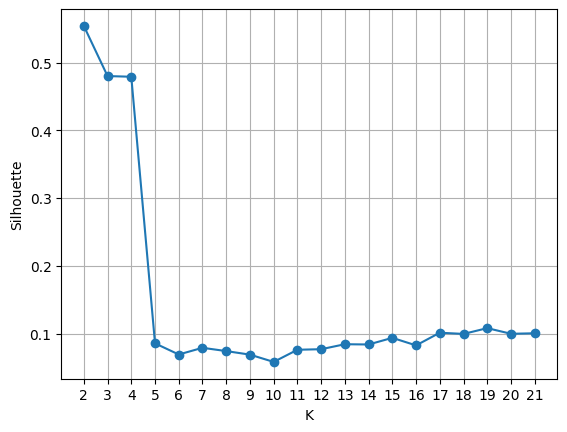

In [74]:
#vamos a usar el método del codo para ver el número óptimo de clusters
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 22):
    km = KMeans(i, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=42)
    clustering = km.fit_predict(X_scaled)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(X_scaled, clustering))

#visualizamos
plt.plot(range(2,22), silhouettes , marker='o')
plt.xticks(range(2, 22))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

### DBSCAN

In [141]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=9.6, min_samples = 4)
clusters = dbscan.fit_predict(X_scaled)

df_pca = pd.DataFrame({'PC1': X_pca_3[:, 0], 'PC2': X_pca_3[:, 1],
                       'PC3': X_pca_3[:, 2], 'cluster': clusters})

fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='cluster', size_max=10)
fig.show()

cliente_features['cluster']= clusters
cliente_features.groupby('cluster').count()

Apollinaris  Augustiner  Bacardi  Beck's  Chardonnay  Club Mate  \
cluster                                                                    
0               6437        6437     6437    6437        6437       6437   
1               3113        3113     3113    3113        3113       3113   
2                227         227      227     227         227        227   
3                223         223      223     223         223        223   

         Coca-Cola  Cranberry Juice  Erdinger Weißbier  Evian  ...  \
cluster                                                        ...   
0             6437             6437               6437   6437  ...   
1             3113             3113               3113   3113  ...   
2              227              227                227    227  ...   
3              223              223                223    223  ...   

         Cranberry Juice & Hohes C Orange  \
cluster                                     
0                                    6437   
1                                    3113   
2                                     227   
3                                     223   

         Cranberry Juice & Passion Fruit Juice  \
cluster                                          
0                                         6437   
1                                         3113   
2                                          227   
3                                          223   

         Cranberry Juice & Rauch Multivitamin  Granini Apple & Hohes C Orange  \
cluster                                                                         
0                                        6437                            6437   
1                                        3113                            3113   
2                                         227                             227   
3                                         223                             223   

         Granini Apple & Tomato Juice  Hohes C Orange & Mango Juice  \
cluster                                                               
0                                6437                          6437   
1                                3113                          3113   
2                                 227                           227   
3                                 223                           223   

         Hohes C Orange & Passion Fruit Juice  \
cluster                                         
0                                        6437   
1                                        3113   
2                                         227   
3                                         223   

         Hohes C Orange & Rauch Multivitamin  Hohes C Orange & Tomato Juice  \
cluster                                                                       
0                                       6437                           6437   
1                                       3113                           3113   
2                                        227                            227   
3                                        223                            223   

         Passion Fruit Juice & Tomato Juice  
cluster                                      
0                                      6437  
1                                      3113  
2                                       227  
3                                       223  

[4 rows x 82 columns]

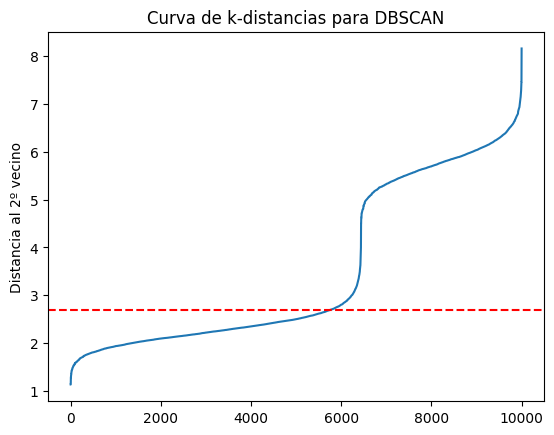

In [118]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Para min_samples=3, usa 2 vecinos
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Ordenar distancias
distances = np.sort(distances[:, 1])  # segunda columna (distancia al 2° vecino)
plt.plot(distances)
plt.axhline(y=2.7, color='r', linestyle='--')
plt.ylabel("Distancia al 2º vecino")
plt.title("Curva de k-distancias para DBSCAN")
plt.show()


In [ ]:
cliente_features = cliente_features.reset_index()
df = df.merge(cliente_features[['customer_id', 'cluster']], on='customer_id', how='left')

customer_id  product  category  region  num_orders  total_quantity  \
cluster_y                                                                       
0               302539   302539    302539  302539      302539          302539   
1               146311   146311    146311  146311      146311          146311   
2                10669    10669     10669   10669       10669           10669   
3                10481    10481     10481   10481       10481           10481   

           total_spent  avg_unit_price  avg_discount  first_order_date  \
cluster_y                                                                
0               302539          302539        302539            302539   
1               146311          146311        146311            146311   
2                10669           10669         10669             10669   
3                10481           10481         10481             10481   

           last_order_date  num_lines  cluster_x  cluster  
cluster_y                                                  
0                   302539     302539     302539   302539  
1                   146311     146311     146311   146311  
2                    10669      10669      10669    10669  
3                    10481      10481      10481    10481

In [ ]:
df['cluster'] = df['cluster_y']
df = df.drop(columns=['cluster_x', 'cluster_y'])

In [160]:
df[['customer_id', 'cluster']].drop_duplicates().groupby('customer_id').size().value_counts()


1    10000
Name: count, dtype: int64

In [170]:
summary = df.groupby('cluster').agg({
    'customer_id': pd.Series.nunique,  # número de clientes únicos
    'num_orders': 'sum',
    'total_quantity': 'sum',
    'total_spent': 'sum',
    'avg_unit_price': 'mean',
    'avg_discount': 'mean',
    'region': lambda x: ', '.join(x.value_counts().head(5).index),  # top 5 regiones
    'category': lambda x: ', '.join(x.value_counts().head(5).index),  # top 5 categorías
    'product': lambda x: ', '.join(x.value_counts().head(5).index),  # top 5 productos
})

def get_top_5_by_quantity(df, col):
    top = (
        df.groupby(['cluster', col])['total_quantity']
        .sum()
        .reset_index()
        .sort_values(['cluster', 'total_quantity'], ascending=[True, False])
        .groupby('cluster')
        .head(5)
        .groupby('cluster')[col]
        .apply(lambda x: ', '.join(x))
    )
    return top

top_regions = get_top_5_by_quantity(df, 'region')
top_categories = get_top_5_by_quantity(df, 'category')
top_products = get_top_5_by_quantity(df, 'product')

# Añadir columnas al resumen
summary['top_regions_by_volume'] = top_regions
summary['top_categories_by_volume'] = top_categories
summary['top_products_by_volume'] = top_products

summary.rename(columns={'customer_id': 'unique_customers',
                        'region': 'top_regions_per_order',
                        'category': 'top_categories_per_order',
                        'product': 'top_products_per_order'}, inplace=True)
summary

unique_customers  num_orders  total_quantity   total_spent  \
cluster                                                               
0                    6437     5795405        46360564  2.750616e+08   
1                    3113     2801369       141521291  7.940451e+08   
2                     227      203465        10271591  4.973840e+07   
3                     223      199671        10087675  5.783608e+07   

         avg_unit_price  avg_discount  \
cluster                                 
0              8.618315      0.000000   
1              8.174205      0.083507   
2              8.105290      0.083335   
3              8.168553      0.083440   

                                     top_regions_per_order  \
cluster                                                      
0        Niedersachsen, Sachsen, Hamburg, Schleswig-Hol...   
1        Hamburg, Hessen, Saarland, Rheinland-Pfalz, Me...   
2                                                   Bremen   
3                                                   Berlin   

                                top_categories_per_order  \
cluster                                                    
0        Alcoholic Beverages, Soft Drinks, Water, Juices   
1        Alcoholic Beverages, Soft Drinks, Water, Juices   
2        Alcoholic Beverages, Soft Drinks, Water, Juices   
3        Alcoholic Beverages, Soft Drinks, Water, Juices   

                                    top_products_per_order  \
cluster                                                      
0        Merlot, Fritz-Kola, Johnnie Walker, Sauvignon ...   
1        Rockstar, Warsteiner, Sauvignon Blanc, Red Bul...   
2        Rauch Multivitamin, Volvic Touch, Beck's, Char...   
3        Vio Wasser, Mountain Dew, Volvic Touch, Schwip...   

                                     top_regions_by_volume  \
cluster                                                      
0        Niedersachsen, Sachsen, Hamburg, Schleswig-Hol...   
1        Hamburg, Hessen, Saarland, Rheinland-Pfalz, Me...   
2                                                   Bremen   
3                                                   Berlin   

                                top_categories_by_volume  \
cluster                                                    
0        Alcoholic Beverages, Juices, Water, Soft Drinks   
1        Alcoholic Beverages, Water, Soft Drinks, Juices   
2        Soft Drinks, Juices, Water, Alcoholic Beverages   
3        Juices, Alcoholic Beverages, Water, Soft Drinks   

                                    top_products_by_volume  
cluster                                                     
0        Hohes C Orange, Granini Apple, Rauch Multivita...  
1        Hohes C Orange, Tomato Juice, Cranberry Juice,...  
2        Beck's, Coca-Cola, Passion Fruit Juice, Tomato...  
3        Fritz-Kola, Sprite, Hohes C Orange, Cranberry ...

In [192]:
# Paso 1: Añadir cluster a l7 mediante merge con df original (customer_id → cluster)
l7_with_cluster = df_l7.merge(
    df[['customer_id', 'cluster']].drop_duplicates(),
    on='customer_id',
    how='left'
)

In [193]:
# Paso 2: Agrupar por cluster y pares de productos y sumar las coocurrencias
cluster_pairs = (
    l7_with_cluster
    .groupby(['cluster', 'product_a', 'product_b'])['cooccurrence_count']
    .sum()
    .reset_index()
)

In [198]:
# Paso 3: Para cada cluster, obtener los top 3 pares más frecuentes
def top_3_pairs_for_cluster(df_cluster):
    top3 = df_cluster.sort_values('cooccurrence_count', ascending=False).head(3)
    return ', '.join(
        f"{row['product_a']} & {row['product_b']} ({row['cooccurrence_count']})"
        for _, row in top3.iterrows()
    )

top_pairs_by_cluster = (
    cluster_pairs
    .groupby('cluster')
    .apply(top_3_pairs_for_cluster)
    .reset_index(name='top_product_pairs_by_cluster')
)

/var/folders/6b/53qw7dps3pvfkphrkbx_yn940000gn/T/ipykernel_57099/2368077657.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
pd.set_option('display.max_colwidth', None)
summary['top_product_pairs_by_customer'] = top_pairs_by_cluster['top_product_pairs_by_cluster']
summary

unique_customers  num_orders  total_quantity   total_spent  \
cluster                                                               
0                    6437     5795405        46360564  2.750616e+08   
1                    3113     2801369       141521291  7.940451e+08   
2                     227      203465        10271591  4.973840e+07   
3                     223      199671        10087675  5.783608e+07   

         avg_unit_price  avg_discount  \
cluster                                 
0              8.618315      0.000000   
1              8.174205      0.083507   
2              8.105290      0.083335   
3              8.168553      0.083440   

                                                            top_regions_per_order  \
cluster                                                                             
0        Niedersachsen, Sachsen, Hamburg, Schleswig-Holstein, Nordrhein-Westfalen   
1              Hamburg, Hessen, Saarland, Rheinland-Pfalz, Mecklenburg-Vorpommern   
2                                                                          Bremen   
3                                                                          Berlin   

                                top_categories_per_order  \
cluster                                                    
0        Alcoholic Beverages, Soft Drinks, Water, Juices   
1        Alcoholic Beverages, Soft Drinks, Water, Juices   
2        Alcoholic Beverages, Soft Drinks, Water, Juices   
3        Alcoholic Beverages, Soft Drinks, Water, Juices   

                                                        top_products_per_order  \
cluster                                                                          
0        Merlot, Fritz-Kola, Johnnie Walker, Sauvignon Blanc, Rotkäppchen Sekt   
1                      Rockstar, Warsteiner, Sauvignon Blanc, Red Bull, Sprite   
2            Rauch Multivitamin, Volvic Touch, Beck's, Chardonnay, Havana Club   
3            Vio Wasser, Mountain Dew, Volvic Touch, Schwip Schwap, Warsteiner   

                                                            top_regions_by_volume  \
cluster                                                                             
0        Niedersachsen, Sachsen, Hamburg, Schleswig-Holstein, Nordrhein-Westfalen   
1              Hamburg, Hessen, Saarland, Rheinland-Pfalz, Mecklenburg-Vorpommern   
2                                                                          Bremen   
3                                                                          Berlin   

                                top_categories_by_volume  \
cluster                                                    
0        Alcoholic Beverages, Juices, Water, Soft Drinks   
1        Alcoholic Beverages, Water, Soft Drinks, Juices   
2        Soft Drinks, Juices, Water, Alcoholic Beverages   
3        Juices, Alcoholic Beverages, Water, Soft Drinks   

                                                                          top_products_by_volume  \
cluster                                                                                            
0        Hohes C Orange, Granini Apple, Rauch Multivitamin, Cranberry Juice, Passion Fruit Juice   
1              Hohes C Orange, Tomato Juice, Cranberry Juice, Granini Apple, Passion Fruit Juice   
2                            Beck's, Coca-Cola, Passion Fruit Juice, Tomato Juice, Granini Apple   
3                              Fritz-Kola, Sprite, Hohes C Orange, Cranberry Juice, Tomato Juice   

                                                                                                  top_product_pairs_by_customer  
cluster                                                                                                                          
0        Hohes C Orange & Mango Juice (24117), Cranberry Juice & Hohes C Orange (24074), Granini Apple & Hohes C Orange (23980)  
1           Granini Apple & Hohes C Orange (11602), Hohes C Orange & Mango Juice (11595), Hohes C Orange & 

In [181]:
pd.reset_option('display.max_colwidth')

## Probabilidad condicionada y lift 

In [ ]:
import pandas as pd

unique_pairs = df_l7[['customer_id', 'product_a', 'product_b']].drop_duplicates()

# Clientes por producto A
customers_per_product_a = (
    unique_pairs[['customer_id', 'product_a']]
    .drop_duplicates()
    .groupby('product_a')['customer_id']
    .nunique()
    .rename('num_customers_a')
)

# Clientes por producto B
customers_per_product_b = (
    unique_pairs[['customer_id', 'product_b']]
    .drop_duplicates()
    .groupby('product_b')['customer_id']
    .nunique()
    .rename('num_customers_b')
)

customers_per_pair = (
    unique_pairs.groupby(['product_a', 'product_b'])['customer_id']
    .nunique()
    .rename('num_customers_ab')
)

total_customers = df_l7['customer_id'].nunique()

df_prob = customers_per_pair.reset_index()

# Añadir num_customers_a para producto_a
df_prob = df_prob.merge(customers_per_product_a.reset_index(), on='product_a')

# Añadir num_customers_b para producto_b
df_prob = df_prob.merge(customers_per_product_b.reset_index(), left_on='product_b', right_on='product_b')

# Calcular probabilidades
df_prob['P_A'] = df_prob['num_customers_a'] / total_customers
df_prob['P_B'] = df_prob['num_customers_b'] / total_customers
df_prob['P_AB'] = df_prob['num_customers_ab'] / total_customers

# Probabilidad condicional P(B|A) = P(A ∩ B) / P(A)
df_prob['P_B_given_A'] = df_prob['P_AB'] / df_prob['P_A']

# Lift = P(A ∩ B) / (P(A)*P(B))
df_prob['lift'] = df_prob['P_AB'] / (df_prob['P_A'] * df_prob['P_B'])

# Ordenar para ver las mejores asociaciones
df_prob = df_prob.sort_values(by='lift', ascending=False)

df_prob.head(20)


                product_a            product_b  num_customers_ab  \
0             Apollinaris           Augustiner              5746   
1080         Volvic Touch           Warsteiner              5697   
590        Hohes C Orange          Mango Juice              9756   
596        Hohes C Orange  Passion Fruit Juice              9751   
609        Hohes C Orange         Tomato Juice              9748   
322       Cranberry Juice   Rauch Multivitamin              9746   
308       Cranberry Juice       Hohes C Orange              9737   
546         Granini Apple         Tomato Juice              9730   
521         Granini Apple       Hohes C Orange              9721   
598        Hohes C Orange   Rauch Multivitamin              9716   
535         Granini Apple   Rauch Multivitamin              9716   
774           Mango Juice         Tomato Juice              9699   
333       Cranberry Juice         Tomato Juice              9697   
314       Cranberry Juice          Mango Juice  

In [203]:
df_prob.head(20)


product_a            product_b  num_customers_ab  \
0             Apollinaris           Augustiner              5746   
1080         Volvic Touch           Warsteiner              5697   
590        Hohes C Orange          Mango Juice              9756   
596        Hohes C Orange  Passion Fruit Juice              9751   
609        Hohes C Orange         Tomato Juice              9748   
322       Cranberry Juice   Rauch Multivitamin              9746   
308       Cranberry Juice       Hohes C Orange              9737   
546         Granini Apple         Tomato Juice              9730   
521         Granini Apple       Hohes C Orange              9721   
598        Hohes C Orange   Rauch Multivitamin              9716   
535         Granini Apple   Rauch Multivitamin              9716   
774           Mango Juice         Tomato Juice              9699   
333       Cranberry Juice         Tomato Juice              9697   
314       Cranberry Juice          Mango Juice              9696   
903   Passion Fruit Juice         Tomato Juice              9696   
533         Granini Apple  Passion Fruit Juice              9692   
320       Cranberry Juice  Passion Fruit Juice              9689   
761           Mango Juice  Passion Fruit Juice              9687   
527         Granini Apple          Mango Juice              9683   
306       Cranberry Juice        Granini Apple              9675   

      num_customers_a  num_customers_b     P_A     P_B    P_AB  P_B_given_A  \
0               10000             5746  1.0000  0.5746  0.5746       0.5746   
1080             5697            10000  0.5697  1.0000  0.5697       1.0000   
590             10000            10000  1.0000  1.0000  0.9756       0.9756   
596             10000            10000  1.0000  1.0000  0.9751       0.9751   
609             10000            10000  1.0000  1.0000  0.9748       0.9748   
322             10000            10000  1.0000  1.0000  0.9746       0.9746   
308             10000            10000  1.0000  1.0000  0.9737       0.9737   
546             10000            10000  1.0000  1.0000  0.9730       0.9730   
521             10000            10000  1.0000  1.0000  0.9721       0.9721   
598             10000            10000  1.0000  1.0000  0.9716       0.9716   
535             10000            10000  1.0000  1.0000  0.9716       0.9716   
774             10000            10000  1.0000  1.0000  0.9699       0.9699   
333             10000            10000  1.0000  1.0000  0.9697       0.9697   
314             10000            10000  1.0000  1.0000  0.9696       0.9696   
903             10000            10000  1.0000  1.0000  0.9696       0.9696   
533             10000            10000  1.0000  1.0000  0.9692       0.9692   
320             10000            10000  1.0000  1.0000  0.9689       0.9689   
761             10000            10000  1.0000  1.0000  0.9687       0.9687   
527             10000            10000  1.0000  1.0000  0.9683       0.9683   
306             10000            10000  1.0000  1.0000  0.9675       0.9675   

        lift  
0     1.0000  
1080  1.0000  
590   0.9756  
596   0.9751  
609   0.9748  
322   0.9746  
308   0.9737  
546   0.9730  
521   0.9721  
598   0.9716  
535   0.9716  
774   0.9699  
333   0.9697  
314   0.9696  
903   0.9696  
533   0.9692  
320   0.9689  
761   0.9687  
527   0.9683  
306   0.9675

In [204]:
(df_prob['lift'] > 1).sum()



np.int64(0)